<a href="https://colab.research.google.com/github/ClaudioRodriguesNunes/analise_de_dados_knn_arvore/blob/main/Titanic_DT_vs_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic — Classificação (Árvore de Decisão vs KNN)

Trabalho prático do **Grupo 2 — Algoritmos de Classificação**, usando o dataset **Titanic**.

**O que este notebook cobre**
- Pré-processamento: imputação, one-hot e padronização quando necessário
- Modelos: **Árvore de Decisão** e **KNN**
- Avaliação: **acurácia**, **matriz de confusão**, **classification report**, **ROC** e **Precision–Recall**
- Extras: **importância das variáveis** e **curva de aprendizado**

**Notas rápidas**
- **KNN** é sensível à escala, então padronizamos as numéricas no pipeline dele.
- **Árvore de Decisão** lida bem com dados mistos e dispensa padronização.
- O alvo é moderadamente desbalanceado; além da acurácia, olhamos **recall** dos sobreviventes.

## 1) Setup

Importa as bibliotecas, define estilo dos gráficos e fixa a semente aleatória. É só o preparo do terreno.

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, learning_curve, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import (
    accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay, mean_absolute_error, PrecisionRecallDisplay, make_scorer,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(context="notebook")

## Carregamento do Titanic e seleção de colunas

Carregamos o Titanic, padronizamos nomes de colunas para **português** e preservamos três dataframes:
- `df_original`: cópia congelada, só para consulta
- `df_trabalho`: tabela de trabalho dentro de cada célula
- `df_atualizado`: consolida o estado “oficial” após cada etapa

Usamos **todas as colunas úteis** (numéricas e categóricas) para análise e modelagem. Evitamos colunas derivadas que vazam informação do alvo.


In [120]:
# Carrega Titanic do seaborn
df_original = sns.load_dataset("titanic").copy()
df_trabalho = df_original.copy()   # área de trabalho

# Significado das colunas originais do dataset Titanic (seaborn/kaggle):
# survived        → 0 = não sobreviveu, 1 = sobreviveu
# pclass          → classe da passagem (1 = 1ª, 2 = 2ª, 3 = 3ª)
# sex             → sexo do passageiro
# age             → idade em anos
# sibsp           → número de irmãos/irmãs e/ou cônjuges a bordo
# parch           → número de pais e/ou filhos a bordo
# fare            → tarifa paga pela passagem
# embarked        → porto de embarque (C = Cherbourg; Q = Queenstown; S = Southampton)
# class           → classe da passagem em texto (First, Second, Third)
# who             → categoria derivada: man, woman, child
# adult_male      → True se adulto masculino, False caso contrário
# deck            → letra do convés da cabine (NaN se não informado)
# embark_town     → nome do porto de embarque (Cherbourg, Queenstown, Southampton)
# alive           → duplicata textual de survived (Yes/No)
# alone           → True se viajando sozinho, False se com família

# Tradução de colunas para português
traducao_colunas = {
    "survived": "sobreviveu",
    "pclass": "classe_passagem",
    "sex": "sexo",
    "age": "idade",
    "sibsp": "irmaos_conjuges",
    "parch": "pais_filhos",
    "fare": "tarifa",
    "embarked": "porto_embarque",
    "class": "classe_texto",
    "who": "quem",
    "adult_male": "adulto_masculino",
    "deck": "convés",
    "embark_town": "cidade_embarque",
    "alive": "esta_vivo",
    "alone": "sozinho"
}

df_trabalho = df_trabalho.rename(columns=traducao_colunas)

target_col = "sobreviveu"
df_trabalho = df_trabalho.dropna(subset=[target_col]).copy()
df_trabalho[target_col] = df_trabalho[target_col].astype(int)

df_atualizado = df_trabalho.copy()

print("Colunas disponíveis:", df_atualizado.columns.tolist())
print("Total de linhas:", len(df_atualizado))
print("Distribuição do alvo:")
print(df_atualizado[target_col].value_counts(normalize=True).round(3))


Colunas disponíveis: ['sobreviveu', 'classe_passagem', 'sexo', 'idade', 'irmaos_conjuges', 'pais_filhos', 'tarifa', 'porto_embarque', 'classe_texto', 'quem', 'adulto_masculino', 'convés', 'cidade_embarque', 'esta_vivo', 'sozinho']
Total de linhas: 891
Distribuição do alvo:
sobreviveu
0    0.616
1    0.384
Name: proportion, dtype: float64


## 3) Engenharia de atributos (básico)

Criamos algumas features úteis:
- `tamanho_familia = irmaos_conjuges + pais_filhos + 1`
- `crianca = 1` se idade < 16
- `adulto_feminino = 1` se sexo == female e não for criança

Essas variáveis ajudam os modelos a capturar padrões de sobrevivência ligados a família e faixa etária.



In [121]:
df_trabalho["tamanho_familia"] = (
    df_trabalho["irmaos_conjuges"].fillna(0) + df_trabalho["pais_filhos"].fillna(0) + 1
)
df_trabalho["crianca"] = (df_trabalho["idade"] < 16).astype("float")
df_trabalho["adulto_feminino"] = (
    (df_trabalho["sexo"] == "female").astype("float") - df_trabalho["crianca"]
)

for col in ["crianca", "adulto_feminino", "adulto_masculino", "sozinho"]:
    if col in df_trabalho.columns:
        df_trabalho[col] = df_trabalho[col].astype("category")

for a, b in [("family_size", "tamanho_familia"), ("is_child", "crianca")]:
    if a in df_trabalho.columns and b in df_trabalho.columns:
        df_trabalho.drop(columns=[a], inplace=True)
    elif a in df_trabalho.columns:
        df_trabalho.rename(columns={a: b}, inplace=True)

banir = {target_col, "esta_vivo"}

features = [c for c in df_trabalho.columns if c not in banir]
X = df_trabalho[features].copy()
y = df_trabalho[target_col].astype(int).copy()

numeric_features = df_trabalho.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = df_trabalho.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

df_atualizado = df_trabalho.copy()

Numéricas: ['sobreviveu', 'classe_passagem', 'idade', 'irmaos_conjuges', 'pais_filhos', 'tarifa', 'tamanho_familia']
Categóricas: ['sexo', 'porto_embarque', 'classe_texto', 'quem', 'adulto_masculino', 'convés', 'cidade_embarque', 'esta_vivo', 'sozinho', 'crianca', 'adulto_feminino']


## 4) Exploração rápida

Aqui verificamos:
- **Missing** por coluna (NaN)
- Distribuições de **idade** e **tarifa**
- Relações básicas com `classe_passagem` e `sexo`

Essa leitura inicial guia as decisões de imputação e de tratamento de outliers.

Total de linhas: 891


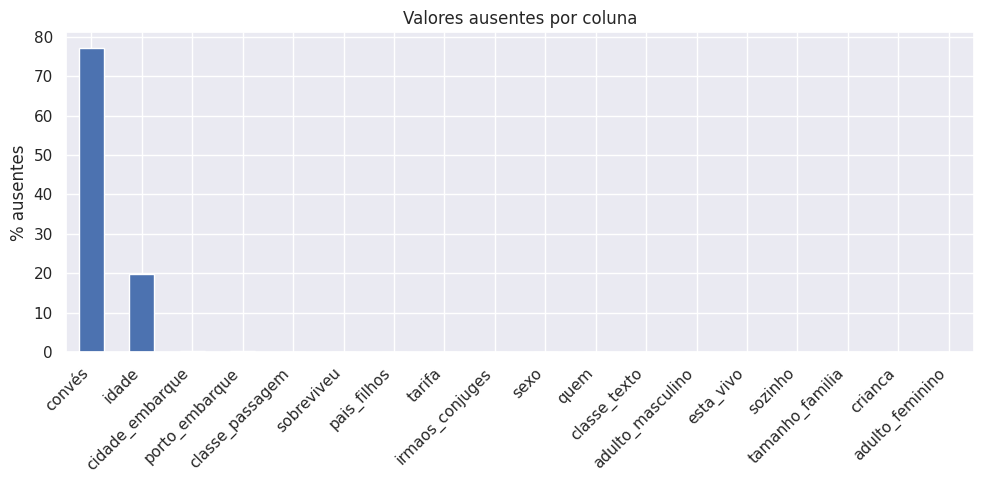

In [122]:
na_counts = df_trabalho.isna().sum()
na_percent = (na_counts / len(df_trabalho)) * 100

na_table = (
    pd.DataFrame({
        "NaN_count": na_counts,
        "NaN_percent": na_percent
    })
    .sort_values("NaN_percent", ascending=False)
    .round(2)
)

print("Total de linhas:", len(df_trabalho))
na_table

plt.figure(figsize=(10,5))
ax = na_table["NaN_percent"].plot(kind="bar")
ax.set_ylabel("% ausentes")
ax.set_title("Valores ausentes por coluna")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Listei apenas colunas com algum NaN. Onde a categoria “MISSING” existia, tratei como ausente para manter a coerência da análise.

In [123]:
na_percent = (df_trabalho.isna().sum() / len(df_trabalho)) * 100

missing_percent = (
    (df_trabalho == "MISSING").sum() / len(df_trabalho) * 100
).sort_values(ascending=False)

na_total = (na_percent + missing_percent).sort_values(ascending=False).round(2)

na_total = na_total[na_total > 0].reset_index()
na_total.columns = ["coluna", "percentual_faltante"]

print("Colunas com dados ausentes (NaN + MISSING):")
print(na_total)



Colunas com dados ausentes (NaN + MISSING):
            coluna  percentual_faltante
0           convés                77.22
1            idade                19.87
2  cidade_embarque                 0.22
3   porto_embarque                 0.22


convés tem cerca de 70% ausentes. Alto o suficiente para precisar de uma estratégia dedicada, não só “moda da coluna”.

## Imputação de `convés` (deck): critérios e validação

**Objetivo.** Reduzir os ausentes em `convés` sem inventar letra impossível, usando o próprio padrão do dataset.

**Regras duras (vindas dos dados).**
- **1ª classe:** pode estar em A/B/C/D/E; nunca F/G.
- **2ª classe:** pode estar em D/E/F; nunca A/B/C/G.
- **3ª classe:** pode estar em E/F/G; nunca A/B/C/D.

**Como decidimos a letra.**
1) Primeiro olhamos **P(deck | classe, faixa_de_tarifa)**. A tarifa separa bem os decks dentro de cada classe.  
2) Se a evidência por faixa estiver fraca ou rara, fazemos **backoff** para **P(deck | classe)** (probabilidade dentro da classe, sem usar a tarifa).  
3) Aplicamos **suavização de Laplace (α = 1)** para evitar contagens zero nas células menos frequentes.

**Validação.**
- Conferimos que a imputação respeitou as restrições (ex.: ninguém da 3ª classe caiu em A/B/C/D).  
- Checamos a distribuição final por classe e por deck, para garantir que não “inflamos” decks raros.  
- Para modelagem, preferimos usar **`faixa_convés`** (baixo/médio/alto) em vez da letra crua, porque captura o sinal socioeconômico com menos ruído.


/tmp/ipython-input-11305506.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


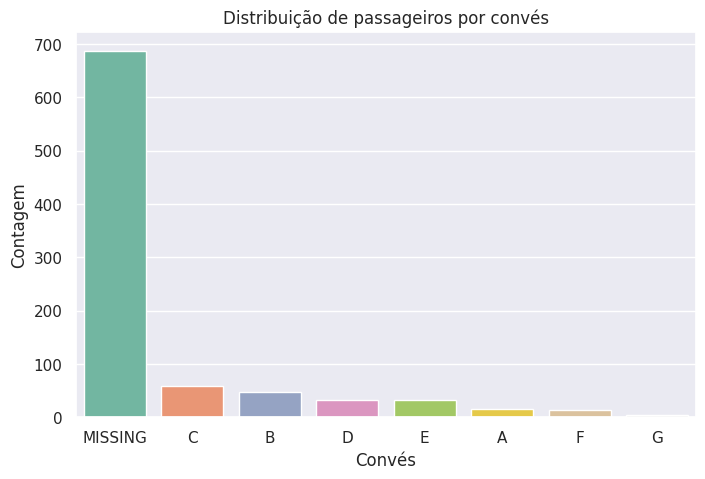

In [124]:
plt.figure(figsize=(8,5))

if "MISSING" not in df_trabalho["convés"].cat.categories:
    df_trabalho["convés"] = df_trabalho["convés"].cat.add_categories("MISSING")

convés_col_filled = df_trabalho["convés"].fillna("MISSING")

sns.countplot(
    x=convés_col_filled,
    order=convés_col_filled.value_counts().index,
    palette="Set2"
)
plt.title("Distribuição de passageiros por convés")
plt.xlabel("Convés")
plt.ylabel("Contagem")
plt.show()

Cruzei convés com variáveis completas e relacionadas, como `tarifa` e `classe_passagem`. Objetivo: entender o padrão socioeconômico de cada deck para orientar a imputação.

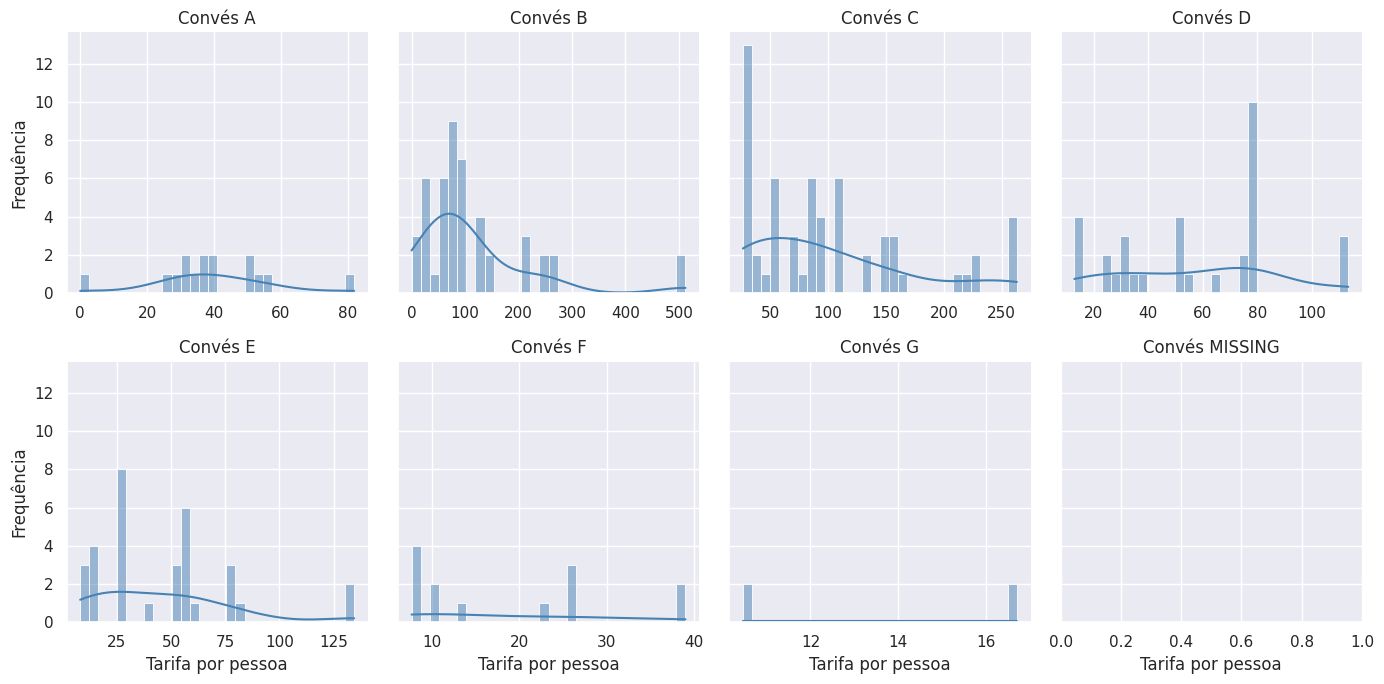

In [125]:
df_sem_na = df_trabalho.dropna(subset=["convés", "tarifa"])

g = sns.FacetGrid(
    df_sem_na,
    col="convés",
    col_wrap=4,
    height=3.5,
    sharex=False,
    sharey=True
)

g.map(
    sns.histplot,
    "tarifa",
    bins=30,
    kde=True,
    color="steelblue"
)

g.set_axis_labels("Tarifa por pessoa", "Frequência")
g.set_titles("Convés {col_name}")
plt.tight_layout()
plt.show()



Este gráfico confirma: grande parte dos NaNs em convés aparece em tarifas mais baixas. Isso reforça a ligação com as classes inferiores.

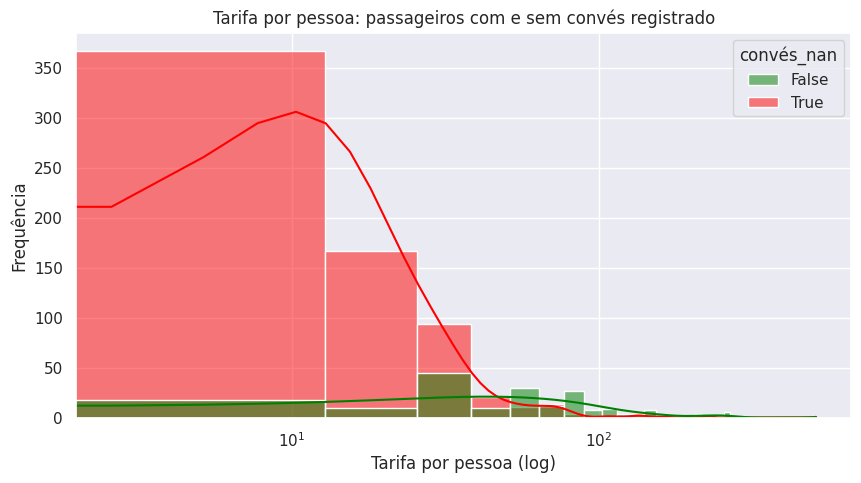

In [126]:
df_trabalho["convés_nan"] = df_trabalho["convés"].isna()

plt.figure(figsize=(10,5))
sns.histplot(
    data=df_trabalho,
    x="tarifa",
    hue="convés_nan",
    bins=40,
    kde=True,
    palette=["green","red"],
    alpha=0.5
)
plt.xscale("log")
plt.xlabel("Tarifa por pessoa (log)")
plt.ylabel("Frequência")
plt.title("Tarifa por pessoa: passageiros com e sem convés registrado")
plt.show()

Comparando tarifas por `deck`: F e G concentram preços mais baixos; A e B concentram os altos. Isso ajuda a definir faixas de `tarifa` que apontem para decks plausíveis.

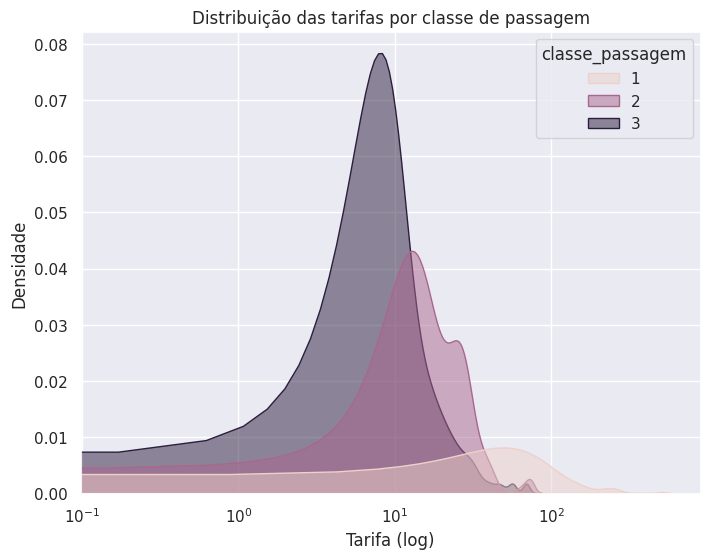

In [127]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    data=df_trabalho,
    x="tarifa",
    hue="classe_passagem",
    common_norm=False,
    fill=True,
    alpha=0.5
)
plt.xscale("log")
plt.xlabel("Tarifa (log)")
plt.ylabel("Densidade")
plt.title("Distribuição das tarifas por classe de passagem")
plt.show()


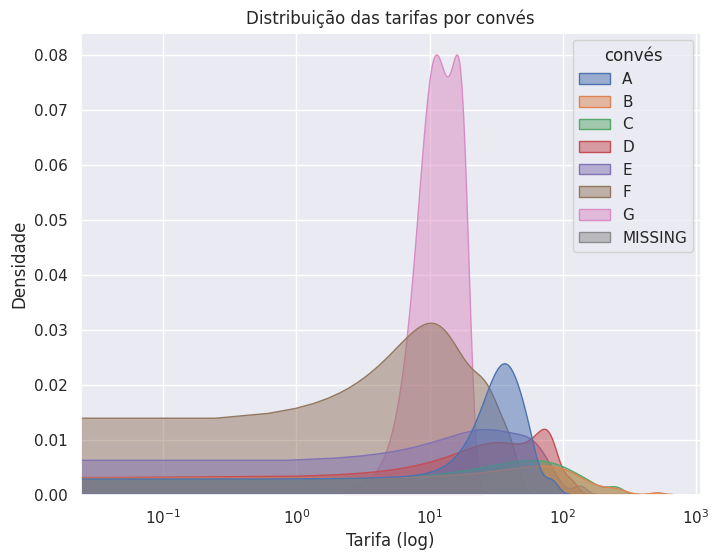

In [128]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    data=df_trabalho,
    x="tarifa",
    hue="convés",
    common_norm=False,
    fill=True,
    alpha=0.5
)
plt.xscale("log")
plt.xlabel("Tarifa (log)")
plt.ylabel("Densidade")
plt.title("Distribuição das tarifas por convés")
plt.show()

Para reduzir NaNs em `convés`, cruzei `classe_passagem × convés` e verifiquei restrições “duras” observadas nos dados (ex.: 3ª classe não aparece em A/B/C/D).

/tmp/ipython-input-1702480313.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_trabalho.groupby(["classe_passagem", "faixa_tarifa"])


=== Contagem absoluta ===
faixa_tarifa     0-9  10-19  20-49  50-99  100-199  200+
classe_passagem                                         
1                  6      0     70     87       33    20
2                  6     98     73      7        0     0
3                324     81     72     14        0     0

=== Percentual dentro de cada classe (%) ===
faixa_tarifa      0-9  10-19  20-49  50-99  100-199  200+
classe_passagem                                          
1                 2.8    0.0   32.4   40.3     15.3   9.3
2                 3.3   53.3   39.7    3.8      0.0   0.0
3                66.0   16.5   14.7    2.9      0.0   0.0


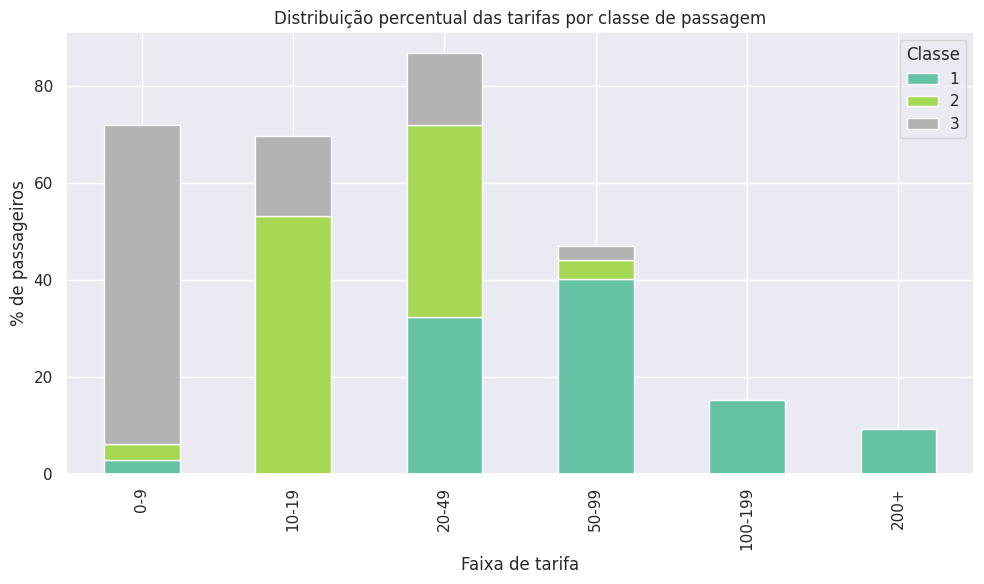

In [129]:
bins = [0, 10, 20, 50, 100, 200, 600]
labels = ["0-9", "10-19", "20-49", "50-99", "100-199", "200+"]

df_trabalho["faixa_tarifa"] = pd.cut(df_trabalho["tarifa"], bins=bins, labels=labels, right=False)

tabela_abs = (
    df_trabalho.groupby(["classe_passagem", "faixa_tarifa"])
    .size()
    .unstack(fill_value=0)
)

tabela_pct = tabela_abs.div(tabela_abs.sum(axis=1), axis=0).round(3) * 100

print("=== Contagem absoluta ===")
print(tabela_abs)
print("\n=== Percentual dentro de cada classe (%) ===")
print(tabela_pct)

tabela_pct.T.plot(
    kind="bar",
    figsize=(10,6),
    stacked=True,
    colormap="Set2"
)
plt.title("Distribuição percentual das tarifas por classe de passagem")
plt.xlabel("Faixa de tarifa")
plt.ylabel("% de passageiros")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3211817298.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_trabalho.groupby(["classe_passagem", "convés"])


=== Contagem absoluta ===
convés            A   B   C   D   E  F  G  MISSING
classe_passagem                                   
1                15  47  59  29  25  0  0        0
2                 0   0   0   4   4  8  0        0
3                 0   0   0   0   3  5  4        0

=== Percentual dentro de cada classe (%) ===
convés             A     B     C     D     E     F     G  MISSING
classe_passagem                                                  
1                8.6  26.9  33.7  16.6  14.3   0.0   0.0      0.0
2                0.0   0.0   0.0  25.0  25.0  50.0   0.0      0.0
3                0.0   0.0   0.0   0.0  25.0  41.7  33.3      0.0


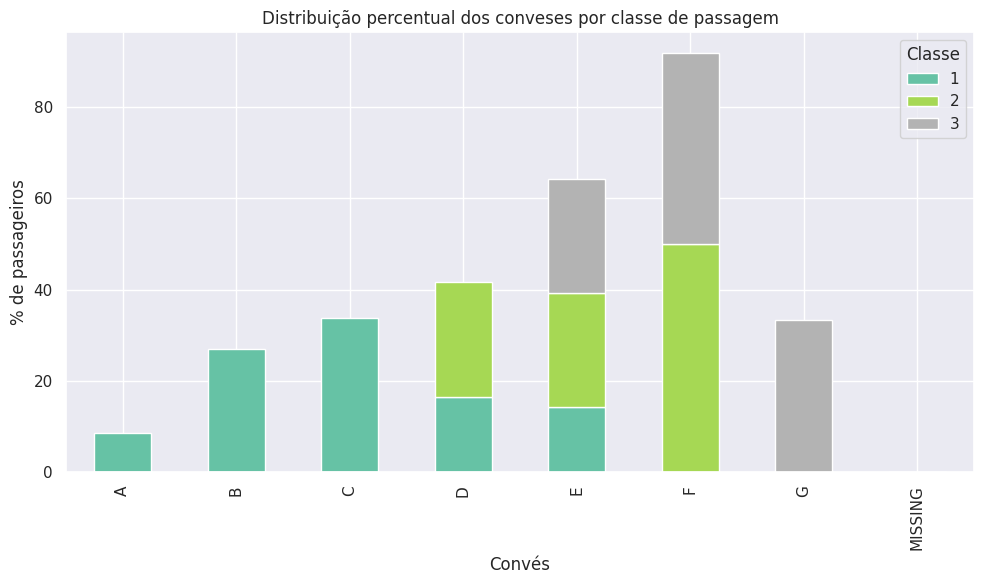

In [130]:
tabela_deck_abs = (
    df_trabalho.groupby(["classe_passagem", "convés"])
    .size()
    .unstack(fill_value=0)
)

tabela_deck_pct = tabela_deck_abs.div(tabela_deck_abs.sum(axis=1), axis=0).round(3) * 100

print("=== Contagem absoluta ===")
print(tabela_deck_abs)
print("\n=== Percentual dentro de cada classe (%) ===")
print(tabela_deck_pct)

tabela_deck_pct.T.plot(
    kind="bar",
    figsize=(10,6),
    stacked=True,
    colormap="Set2"
)
plt.title("Distribuição percentual dos conveses por classe de passagem")
plt.xlabel("Convés")
plt.ylabel("% de passageiros")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()


### Estratégia de imputação do convés (deck)

Depois de explorar o dataset com cruzamentos entre classe_passagem, tarifa e convés, adotei as seguintes restrições duras (nunca violadas no imputador):

* 1ª classe: só pode estar em A, B, C, D, E. Nunca F nem G.
* 2ª classe: só pode estar em D, E, F. Nunca A, B, C nem G.
* 3ª classe: só pode estar em E, F, G. Nunca A, B, C nem D.

Estas restrições saem diretamente da distribuição observada. Não é chute; é o que os dados mostram.

Usei P(deck | classe, faixa_tarifa) com backoff para P(deck | classe).
* Decidi convés (deck) usando a probabilidade condicional por faixa de tarifa.  Caso há poucos dados ou ruidosa (outleirs, por exemplo), reduzi para distribuição global, isto é, decidindo o convés (deck) usando somente a classe.

* *Faixa de tarifa por classe* - No primeiro momento tentei com faixas iguais para todas as classes, porém os poucos dados principalmente da primeira classe, ou mais especificamente do convés (deck) A,B e E, me fez tratar de forma diferente a quantidade de quantis e ajustes destes dentro de cada classe.
  * 1ª classe: 3 faixas (quantis 0–50%–85%–100%)
  * 2ª classe: 2 faixas (0–60%–100%)
  * 3ª classe: 5 faixas (0–20–40–60–80–100%)
  Essa granularidade foi a que deu o melhor equilíbrio entre “sensibilidade” e “não esvaziar as células”.

* *Classe 3: default = MISSING* - A terceira classe quase nunca tem convés registrado. Então a decisão padrão é MISSING e só mudo para E/F/G quando P(deck | classe=3, faixa_tarifa) é claramente dominante (acima de um limiar razoável).

* *Suavização de Laplace (alpha = 1.0)* - Este recurso eu aprendi e apliquei conforme eu pesquisei na internet.  Achei interessante a resposta. Quando calculamos frequências por célula (classe × faixa × deck), algumas classes raras podem aparecer com zero contagens. A “suavização de Laplace” soma alpha a todas as contagens antes de normalizar, evitando zeros absolutos.
Com alpha = 1.0, todo deck permitido ganha +1 “contagem virtual”. Isso impede que uma classe rara seja descartada só porque, naquele recorte específico, caiu em 0 por acaso. É uma proteção estatística simples e eficaz para dados esparsos.

* *Determinístico* - Respeitando as regras, o deck escolhido será sempre o mais provável. Nâo é sorteio e nem ruído aleatório.  Se houver empate, a decisão é com regras claras (veja no código).  Por isso eu garanti que se repetir o processo, o resultado será o mesmo.

## Por que validei só 1ª e 2ª classes?

Validei a imputação apenas nas classes 1 e 2, porque o convés é um atributo físico dessas classes no dataset (existe letra A–F com frequência razoável).
Na 3ª classe, o regime natural é MISSING, e “acertar” uma letra A–G não considerei algo sensato. O que interessa para a modelagem é a faixa_convés (baixo/médio/alto), não forçar uma letra inexistente.

## Resultado e decisão

* O método enxuto (restrições duras + quantis por classe + P(deck|classe,faixa) com backoff e Laplace=1) foi o que apresentou melhor equilíbrio nas métricas que importam para 1ª e 2ª classes.

* Tentativas de “ficar esperto” com porta de embarque, funis hierárquicos extras e desempates por mediana pioraram o desempenho por falta de evidência robusta e rarefação das células.

In [131]:
df_trabalho = df_atualizado.copy()

allowed_by_class = {
    1: set(list("ABCDE")),
    2: set(list("DEF")),
    3: set(list("EFG")),
}

quantiles_per_class = {
    1: (0.00, 0.50, 0.85, 1.00),                 # 3 bins dentro da 1ª
    2: (0.00, 0.60, 1.00),                       # 2 bins na 2ª
    3: (0.00, 0.20, 0.40, 0.60, 0.80, 1.00),     # 5 bins na 3ª (tem volume)
}

def build_bins_per_class(df, quantiles_per_class):
    bins_map = {}
    for c, qs in quantiles_per_class.items():
        fares = df.loc[(df["classe_passagem"] == c) & df["tarifa"].notna(), "tarifa"].values
        if len(fares) < 5:
            if len(fares) == 0:
                bins_map[c] = [0.0, 1.0]
            else:
                bins_map[c] = [float(np.nanmin(fares)), float(np.nanmax(fares))]
            continue
        qvals = np.quantile(fares, qs)
        edges = np.unique(qvals).tolist()
        if len(edges) < 2:
            edges = [float(np.nanmin(fares)), float(np.nanmax(fares))]
        bins_map[c] = edges
    return bins_map

bins_map = build_bins_per_class(df_trabalho, quantiles_per_class)

def fare_bin_index(row):
    c = row["classe_passagem"]
    f = row["tarifa"]
    if pd.isna(c) or pd.isna(f) or c not in bins_map:
        return np.nan
    edges = bins_map[c]
    if len(edges) < 2:
        return 0
    idx = np.searchsorted(edges, f, side="right") - 1
    idx = max(0, min(idx, len(edges)-2))
    return idx

df_trabalho["_faixa_tarifa_idx"] = df_trabalho.apply(fare_bin_index, axis=1)

mask_real_deck = df_trabalho["convés"].isin(list("ABCDEFG"))
df_known = df_trabalho.loc[mask_real_deck & df_trabalho["_faixa_tarifa_idx"].notna()].copy()

def train_tables(dfk, alpha=1.0):
    tables = {}
    for c in sorted(dfk["classe_passagem"].dropna().unique()):
        allowed = allowed_by_class[c]
        sub = dfk[dfk["classe_passagem"] == c]

        counts_base = sub["convés"].value_counts()
        for d in allowed:
            if d not in counts_base:
                counts_base[d] = 0
        counts_base = counts_base[sorted(allowed)]
        counts_base = counts_base + alpha
        base = (counts_base / counts_base.sum()).sort_values(ascending=False)

        cond = {}
        for idx in sorted(sub["_faixa_tarifa_idx"].dropna().unique()):
            sub2 = sub[sub["_faixa_tarifa_idx"] == idx]
            counts = sub2["convés"].value_counts()
            for d in allowed:
                if d not in counts:
                    counts[d] = 0
            counts = counts[sorted(allowed)] + alpha
            vc = (counts / counts.sum()).sort_values(ascending=False)
            cond[idx] = vc

        tables[c] = {"base": base, "cond": cond}
    return tables

tables = train_tables(df_known, alpha=1.0)

def predict_deck(row, threshold_c3=0.2, lam_c1=0.6, lam_c2=0.7):
    c = row["classe_passagem"]
    if pd.isna(c):
        return "MISSING"
    c = int(c)
    fidx = row["_faixa_tarifa_idx"]

    if c == 3:
        cond_tbl = (tables.get(c, {}).get("cond") or {}).get(fidx, pd.Series(dtype=float))
        if len(cond_tbl) >= 1 and cond_tbl.iloc[0] >= threshold_c3:
            return cond_tbl.index[0]
        return "MISSING"

    base_tbl = tables.get(c, {}).get("base", pd.Series(dtype=float))
    cond_tbl = (tables.get(c, {}).get("cond") or {}).get(fidx, pd.Series(dtype=float))

    if len(base_tbl) == 0 and len(cond_tbl) == 0:
        return sorted(list(allowed_by_class[c]))[0]

    allowed = sorted(list(allowed_by_class[c]))
    base_tbl = base_tbl.reindex(allowed).fillna(0.0)
    cond_tbl = cond_tbl.reindex(allowed).fillna(0.0) if len(cond_tbl) else pd.Series(0.0, index=allowed)

    lam = lam_c1 if c == 1 else lam_c2
    blended = lam * cond_tbl + (1 - lam) * base_tbl
    s = blended.sum()
    if s > 0:
        blended = blended / s

    return blended.sort_values(ascending=False).index[0]

needs_impute = ~df_trabalho["convés"].isin(list("ABCDEFG"))
df_trabalho.loc[needs_impute, "convés"] = df_trabalho.loc[needs_impute].apply(predict_deck, axis=1)

mask_eval = df_trabalho["convés"].isin(list("ABCDEFG")) & df_trabalho["classe_passagem"].isin([1, 2])
X_eval = df_trabalho.loc[mask_eval, ["classe_passagem", "tarifa", "_faixa_tarifa_idx", "convés"]].copy()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, test_idx) = next(sss.split(X_eval, X_eval["classe_passagem"]))
train_df = X_eval.iloc[train_idx].copy()
test_df  = X_eval.iloc[test_idx].copy()

tables_holdout = train_tables(train_df, alpha=1.0)

def predict_with_tables(row, tables_, lam_c1=0.6, lam_c2=0.7):
    c = int(row["classe_passagem"])
    fidx = row["_faixa_tarifa_idx"]
    base_tbl = tables_.get(c, {}).get("base", pd.Series(dtype=float))
    cond_tbl = (tables_.get(c, {}).get("cond") or {}).get(fidx, pd.Series(dtype=float))
    allowed = sorted(list(allowed_by_class[c]))
    base_tbl = base_tbl.reindex(allowed).fillna(0.0)
    cond_tbl = cond_tbl.reindex(allowed).fillna(0.0) if len(cond_tbl) else pd.Series(0.0, index=allowed)
    lam = lam_c1 if c == 1 else lam_c2
    blended = lam * cond_tbl + (1 - lam) * base_tbl
    s = blended.sum()
    if s > 0:
        blended = blended / s
    return blended.sort_values(ascending=False).index[0]

y_true = test_df["convés"].values
y_pred = test_df.apply(lambda r: predict_with_tables(r, tables_holdout), axis=1).values

print("Relatório (classes 1 e 2):")
print(classification_report(y_true, y_pred, zero_division=0))
labels_12 = sorted(list(allowed_by_class[1] | allowed_by_class[2]))  # A,B,C,D,E,F
print("Matriz de confusão (labels ordenados):")
print(labels_12)
print(confusion_matrix(y_true, y_pred, labels=labels_12))

df_atualizado = df_trabalho.copy()


Relatório (classes 1 e 2):
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         2
           B       0.00      0.00      0.00         8
           C       0.44      1.00      0.61        19
           D       0.00      0.00      0.00         8
           E       0.00      0.00      0.00         8
           F       0.95      1.00      0.97        35

    accuracy                           0.68        80
   macro avg       0.23      0.33      0.26        80
weighted avg       0.52      0.68      0.57        80

Matriz de confusão (labels ordenados):
['A', 'B', 'C', 'D', 'E', 'F']
[[ 0  0  2  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 19  0  0  0]
 [ 0  0  7  0  0  1]
 [ 0  0  7  0  0  1]
 [ 0  0  0  0  0 35]]


A tabela confirma a redução dos ausentes em `convés` dentro das restrições por classe. Não forçamos letras impossíveis para a 3ª classe.

In [132]:
na_percent = (df_trabalho.isna().sum() / len(df_trabalho)) * 100

missing_percent = (
    (df_trabalho == "MISSING").sum() / len(df_trabalho) * 100
).sort_values(ascending=False)

na_total = (na_percent + missing_percent).sort_values(ascending=False).round(2)

na_total = na_total[na_total > 0].reset_index()
na_total.columns = ["coluna", "percentual_faltante"]

print("Colunas com dados ausentes (NaN + MISSING):")
print(na_total)

Colunas com dados ausentes (NaN + MISSING):
            coluna  percentual_faltante
0            idade                19.87
1   porto_embarque                 0.22
2  cidade_embarque                 0.22


Mais uma tabela que mostra como ficou a distribuição dos passageiros após o tratamento em relação a classe x convés.

=== Contagem absoluta ===
convés            A   B    C   D    E    F    G
classe_passagem                                
1                15  47  100  29   25    0    0
2                 0   0    0   4    4  176    0
3                 0   0    0   0  112  272  107

=== Percentual dentro de cada classe (%) ===
convés             A     B     C     D     E     F     G
classe_passagem                                         
1                6.9  21.8  46.3  13.4  11.6   0.0   0.0
2                0.0   0.0   0.0   2.2   2.2  95.7   0.0
3                0.0   0.0   0.0   0.0  22.8  55.4  21.8


/tmp/ipython-input-2345364096.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_trabalho.groupby(["classe_passagem", "convés"])


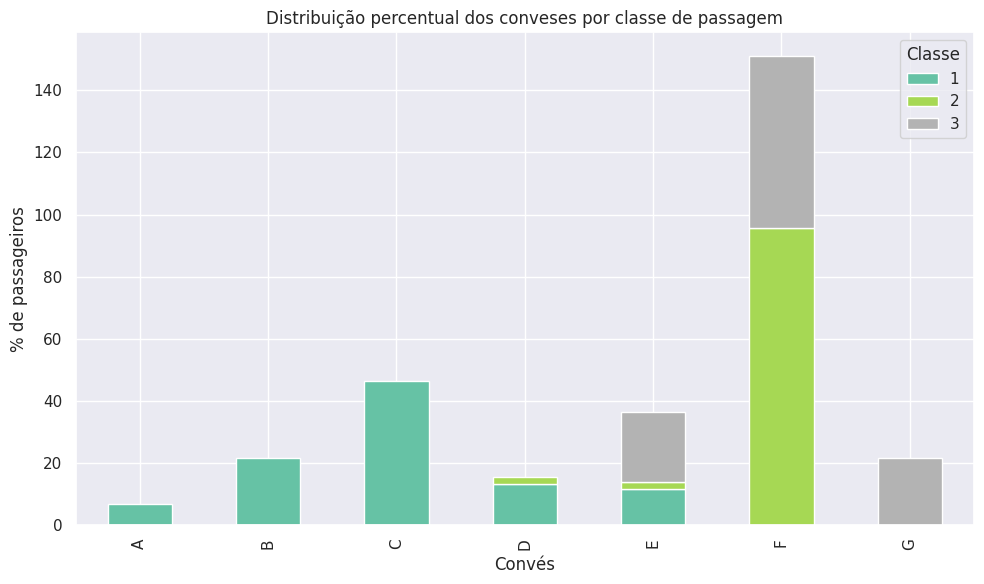

In [133]:
tabela_deck_abs = (
    df_trabalho.groupby(["classe_passagem", "convés"])
    .size()
    .unstack(fill_value=0)
)

tabela_deck_pct = tabela_deck_abs.div(tabela_deck_abs.sum(axis=1), axis=0).round(3) * 100

print("=== Contagem absoluta ===")
print(tabela_deck_abs)
print("\n=== Percentual dentro de cada classe (%) ===")
print(tabela_deck_pct)

tabela_deck_pct.T.plot(
    kind="bar",
    figsize=(10,6),
    stacked=True,
    colormap="Set2"
)
plt.title("Distribuição percentual dos conveses por classe de passagem")
plt.xlabel("Convés")
plt.ylabel("% de passageiros")
plt.legend(title="Classe")
plt.tight_layout()
plt.show()

## Imputação da Idade

Nestas tabelas verifiquei se realmente a quantidade de homens está correto em adult_man

In [134]:
contagem_who = df_trabalho["quem"].value_counts(dropna=False)

contagem_adult_male = df_trabalho["adulto_masculino"].value_counts(dropna=False)

print("Distribuição da coluna 'quem':")
print(contagem_who)
print("\nDistribuição da coluna 'adulto_masculino':")
print(contagem_adult_male)

comparacao = pd.crosstab(df_trabalho["quem"], df_trabalho["adulto_masculino"])
print("\nCruzamento entre 'quem' e 'adulto_masculino':")
print(comparacao)


Distribuição da coluna 'quem':
quem
man      537
woman    271
child     83
Name: count, dtype: int64

Distribuição da coluna 'adulto_masculino':
adulto_masculino
True     537
False    354
Name: count, dtype: int64

Cruzamento entre 'quem' e 'adulto_masculino':
adulto_masculino  False  True
quem                         
child                83     0
man                   0   537
woman               271     0


### Estratégia de Imputação da Idade

### Imputação de idade: diagnóstico, escolhas e validação

**Objetivo**: imputar idade sem vazamento e sem colapsar a variabilidade. O perfil dos faltantes difere por classe_passagem, então a decisão é feita por classe.

### Diagnóstico dos faltantes

Mapeei apenas os NaN de idade por classe_passagem × quem × sexo.
Após a exploração de dados no decorrer desse notebook identifiquei que a coluna WHO divide os passageiros em três distintos grupos que tem relação com a IDADE.  Que este grupo tem relação parcial com o SEX (homem e mulher.  Criança aqui não tem sexo) e por fim tem relação a distribuição coom PCLASS.
* **Classe 1**: faltantes mistos (homens e mulheres), volume razoável.
* **Classe 2**: poucos faltantes; não justifica modelo complexo.
* **Classe 3**: faltantes numerosos e heterogêneos; precisa de algo mais robusto que uma mediana qualquer.

### Variáveis usadas (sem vazamento)

Apenas features “limpas”: classe_passagem, tarifa, tarifa_log, irmaos_conjuges, pais_filhos, quem, sexo, sozinho.
Nada de convés ou derivados imputados antes.  O motivo é para evitar vazamento de dados.

### Tratamentos prévios relevantes

* Winsorização por classe em tarifa (p1–p99) e criação de tarifa_log = log1p(tarifa).
  1.   “Por classe” evita cortes injustos entre grupos com escalas distintas.
  2.   log1p lida com tarifas zero e reduz assimetria, essencial para KNN e útil para regressão.
* Idade: clip apenas no topo via IQR; limite inferior fixado em 0 para não “matar” bebês reais.

### Regras de decisão por classe

* Classe 2 → Mediana por grupo (quem × sexo). Faltantes poucos; solução simples e estável.
* Classes 1 e 3 → decisão por validação (CV k-fold=5) entre:
  1. Mediana por grupo (quem × sexo)
  2. Ridge (regressão com penalização L2)
  3. KNN Regressor com StandardScaler
    
    Ganha quem tiver menor MAE nos registros conhecidos daquela classe. Se os faltantes forem homogêneos (um único perfil), mediana é preferida pela robustez.


> k-fold=5: equilíbrio entre estabilidade da métrica e custo computacional. k maior estabiliza mais, mas aumenta custo e pode supervalorizar diferenças marginalmente pequenas; k menor oscila demais.  Preferi usar o 5, pois é um exercicio.  Mas cheguei simular e gerou algumas informações que não consegui tratar.

### Resultado da comparação

* Classe 1: KNN venceu. Com tarifa_log e escala, o vizinho ficou sensato e capturou nuances.
* Classe 2: Mediana bastou.
* Classe 3: Ridge venceu. Havia muita variabilidade e colinearidade leve entre tarifa, classe_passagem e variáveis de família.
  1. Colinearidade: features redundantes entre si deixam os coeficientes instáveis na regressão comum.
  2. Overfit: aprender ruído do treino e errar no teste; mais provável em classe grande e heterogênea.
  3. Ridge (L2): encolhe coeficientes, estabiliza sob colinearidade e controla overfit. Mesmo com tarifa_log, o cenário da 3ª classe favoreceu a regularização.

### Pós-imputação

* Recalculei crianca = (idade < 16).
* Sanity checks lógicos (ex.: child ≥ 16, adulto_masculino com idade < 16).
* Idade limitada a [0, 80] por higiene.

### Conclusão

* Classe 1: KNN
* Classe 2: Mediana (quem × sexo)
* Classe 3: Ridge
* Escolha baseada em CV por classe, MAE, sem vazamento, com winsorização por classe e tarifa_log para estabilizar a escala. É defensável tecnicamente e consistente com as distribuições dos próprios dados.

In [135]:
df_trabalho = df_atualizado.copy()
df_trabalho["idade_era_nan"] = df_trabalho["idade"].isna().astype(int)

mask_miss = df_trabalho["idade"].isna()

print("=== Missing de IDADE por classe × quem ===")
tab1 = (df_trabalho[mask_miss]
        .groupby(["classe_passagem","quem"])["idade"]
        .size()
        .unstack(fill_value=0)
        .sort_index())
print(tab1)

print("\n=== Missing de IDADE por classe × quem × sexo ===")
tab2 = (df_trabalho[mask_miss]
        .groupby(["classe_passagem","quem","sexo"])["idade"]
        .size()
        .reset_index(name="qtd")
        .sort_values(["classe_passagem","quem","sexo"]))
print(tab2)

SAFE_FEATURES = ["classe_passagem","tarifa","irmaos_conjuges","pais_filhos","quem","sexo","sozinho"]

def mae_mediana_cv(df_class, folds=5, random_state=42):
    """CV honesto para a estratégia da mediana por (quem, sexo) dentro da classe."""
    sub = df_class[df_class["idade"].notna()].copy()
    if sub.empty:
        return np.inf

    keys = sub[["quem","sexo"]].reset_index(drop=True)
    y_true = sub["idade"].reset_index(drop=True).to_numpy()

    kf = KFold(n_splits=min(folds, len(sub)), shuffle=True, random_state=random_state)
    maes = []
    for tr, te in kf.split(keys):
        train = keys.iloc[tr].copy()
        test  = keys.iloc[te].copy()
        y_tr  = y_true[tr]
        y_te  = y_true[te]

        aux = train.copy()
        aux["idade"] = y_tr
        med_grp = aux.groupby(["quem","sexo"])["idade"].median()
        med_global = float(np.median(y_tr))

        y_hat = []
        for i, row in test.iterrows():
            key = (row["quem"], row["sexo"])
            y_hat.append(med_grp.get(key, med_global))
        maes.append(mean_absolute_error(y_te, y_hat))
    return float(np.mean(maes))

def build_Xy(df_class):
    """One-hot nas categóricas e retorna X, y, colunas."""
    cols = SAFE_FEATURES + ["idade"]
    sub = pd.get_dummies(df_class[cols], drop_first=True)
    known = sub["idade"].notna()
    X = sub.loc[known].drop(columns=["idade"])
    y = sub.loc[known, "idade"].astype(float)
    X_missing = sub.loc[~known].drop(columns=["idade"])
    return X, y, X_missing, sub.columns.drop("idade")

def evaluate_models_for_class(df_class, cv=5):
    """Avalia Mediana vs Ridge vs KNN na classe (apenas conhecidos)."""
    mae_med = mae_mediana_cv(df_class, folds=cv)

    X, y, _, _ = build_Xy(df_class)
    if len(X) < cv:
        return {"mediana": mae_med, "ridge": np.inf, "knn": np.inf}

    ridge = GridSearchCV(
        Ridge(),
        param_grid={"alpha":[0.1, 0.5, 1.0, 2.0, 5.0]},
        scoring="neg_mean_absolute_error",
        cv=cv
    )
    ridge.fit(X, y)
    mae_ridge = -ridge.best_score_

    pipe_knn = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor())
    ])
    knn_gs = GridSearchCV(
        pipe_knn,
        param_grid={
            "knn__n_neighbors":[5,7,9,11],
            "knn__weights":["uniform","distance"],
            "knn__p":[1,2]
        },
        scoring="neg_mean_absolute_error",
        cv=cv
    )
    knn_gs.fit(X, y)
    mae_knn = -knn_gs.best_score_

    return {"mediana": mae_med, "ridge": mae_ridge, "knn": mae_knn,
            "_best_ridge": ridge.best_estimator_, "_best_knn": knn_gs.best_estimator_}

def impute_with_median(df_class):
    """Imputa NaN de idade por mediana (quem, sexo) dentro da classe, com fallback na mediana global da classe."""
    out = df_class.copy()
    med_grp = out.groupby(["quem","sexo"])["idade"].median()
    med_global = out["idade"].median()
    def fill_row(row):
        if pd.isna(row["idade"]):
            return med_grp.get((row["quem"], row["sexo"]), med_global)
        return row["idade"]
    out["idade"] = out.apply(fill_row, axis=1)
    return out

def train_and_impute_model(df_class, model):
    """Treina modelo na classe (conhecidos) e imputa NaN com o modelo."""
    out = df_class.copy()
    X_known, y_known, X_missing, _ = build_Xy(df_class)
    if len(X_known) == 0 or len(X_missing) == 0:
        return out
    model.fit(X_known, y_known)
    preds = model.predict(X_missing)
    mask = out["idade"].isna()
    out.loc[mask, "idade"] = preds
    return out

df_final_parts = []
summary = []

for c in [1,2,3]:
    df_c = df_trabalho[df_trabalho["classe_passagem"] == c].copy()
    n_total = len(df_c)
    n_miss  = df_c["idade"].isna().sum()
    if n_total == 0 or n_miss == 0:
        df_final_parts.append(df_c)
        summary.append((c, "sem_missing", n_total, n_miss, None, None))
        continue

    miss_profiles = (df_c[df_c["idade"].isna()]
                     .groupby(["quem","sexo"])["idade"]
                     .size()
                     .reset_index(name="qtd"))
    n_profiles = len(miss_profiles)

    if c == 2:
        chosen = "mediana"
        df_c_imp = impute_with_median(df_c)

    else:
        if n_profiles <= 1:
            chosen = "mediana"
            df_c_imp = impute_with_median(df_c)
        else:
            scores = evaluate_models_for_class(df_c, cv=5)
            best_name = min({"mediana":scores["mediana"], "ridge":scores["ridge"], "knn":scores["knn"]}, key=lambda k: scores[k])
            chosen = best_name
            if best_name == "mediana" or np.isinf(scores[best_name]):
                df_c_imp = impute_with_median(df_c)
            elif best_name == "ridge":
                df_c_imp = train_and_impute_model(df_c, scores["_best_ridge"])
            else:
                df_c_imp = train_and_impute_model(df_c, scores["_best_knn"])

    df_c_imp["idade"] = df_c_imp["idade"].clip(lower=0, upper=80)

    df_final_parts.append(df_c_imp)
    summary.append((c, chosen, n_total, n_miss, n_profiles,
                    miss_profiles.sort_values("qtd", ascending=False).to_dict(orient="records")))

df_trabalho = pd.concat(df_final_parts, axis=0).sort_index()

df_trabalho["crianca"] = (df_trabalho["idade"] < 16).astype("float")

print("\n=== Estratégia adotada por classe ===")
for c, chosen, n_total, n_miss, n_profiles, profiles in summary:
    print(f"Classe {c}: estratégia = {chosen} | total={n_total} | missing={n_miss} | perfis_missing={n_profiles}")
    if isinstance(profiles, list):
        for p in profiles:
            print(f"   - {p}")

df_atualizado = df_trabalho.copy()
print("\nImputação de idade concluída por classe e consolidada em df_atualizado.")


=== Missing de IDADE por classe × quem ===
quem             man  woman
classe_passagem            
1                 21      9
2                  9      2
3                 94     42

=== Missing de IDADE por classe × quem × sexo ===
   classe_passagem   quem    sexo  qtd
0                1    man    male   21
1                1  woman  female    9
2                2    man    male    9
3                2  woman  female    2
4                3    man    male   94
5                3  woman  female   42

=== Estratégia adotada por classe ===
Classe 1: estratégia = knn | total=216 | missing=30 | perfis_missing=2
   - {'quem': 'man', 'sexo': 'male', 'qtd': 21}
   - {'quem': 'woman', 'sexo': 'female', 'qtd': 9}
Classe 2: estratégia = mediana | total=184 | missing=11 | perfis_missing=2
   - {'quem': 'man', 'sexo': 'male', 'qtd': 9}
   - {'quem': 'woman', 'sexo': 'female', 'qtd': 2}
Classe 3: estratégia = ridge | total=491 | missing=136 | perfis_missing=2
   - {'quem': 'man', 'sexo': 'male', 

Nesta etapa, quis verificar de forma explícita como a imputação de idades foi aplicada e onde exatamente ela ocorreu. Como o processo foi feito de forma estratificada por classe social (pclass), era importante confirmar que cada estratégia (KNN, Mediana, Ridge) foi de fato usada dentro da sua respectiva classe e não de maneira global. Essa checagem me permite saber quais perfis de passageiros tiveram idades reconstruídas e avaliar se o resultado final está coerente com o diagnóstico inicial dos faltantes.

Essa análise também me ajuda a medir se houve impacto desproporcional em alguma classe (ex.: mais imputações na 3ª do que na 1ª), o que pode influenciar diretamente os modelos de classificação posteriores.

In [136]:
print("Imputados por classe:")
print(df_atualizado.groupby("classe_passagem")["idade_era_nan"].sum())

print("\nImputados por classe × quem:")
print(df_atualizado.groupby(["classe_passagem","quem"])["idade_era_nan"].sum())

desc = (
    df_atualizado
    .assign(grupo=np.where(df_atualizado["idade_era_nan"]==1, "imputada", "conhecida"))
    .groupby(["classe_passagem","grupo"])["idade"]
    .describe()[["count","mean","std","50%","min","max"]]
    .round(2)
)
print("\nIdade: conhecidos vs imputados por classe (descrição):")
print(desc)

incons1 = ((df_atualizado["idade"] < 16) & (df_atualizado["adulto_masculino"] == 1)).sum()
incons2 = ((df_atualizado["quem"] == "child") & (df_atualizado["idade"] >= 16)).sum()
incons3 = ((df_atualizado["quem"].isin(["man","woman"])) & (df_atualizado["idade"] < 12)).sum()

print("\nInconsistências:")
print(f"- criança (<16) marcada como adulto_masculino: {incons1}")
print(f"- 'child' com idade >= 16: {incons2}")
print(f"- 'man/woman' com idade < 12: {incons3}")


Imputados por classe:
classe_passagem
1     30
2     11
3    136
Name: idade_era_nan, dtype: int64

Imputados por classe × quem:
classe_passagem  quem 
1                child     0
                 man      21
                 woman     9
2                child     0
                 man       9
                 woman     2
3                child     0
                 man      94
                 woman    42
Name: idade_era_nan, dtype: int64

Idade: conhecidos vs imputados por classe (descrição):
                           count   mean    std    50%    min    max
classe_passagem grupo                                              
1               conhecida  186.0  38.23  14.80  37.00   0.92  80.00
                imputada    30.0  39.50   7.32  40.90  25.00  51.00
2               conhecida  173.0  29.88  14.00  29.00   0.67  70.00
                imputada    11.0  30.82   0.40  31.00  30.00  31.00
3               conhecida  355.0  25.14  12.50  24.00   0.42  74.00
                imput

A verificação mostra que os NaNs de idade foram imputados conforme o plano por classe (KNN na 1ª, Mediana na 2ª, Ridge na 3ª), e crianca foi recalculado.

In [137]:
na_percent = (df_trabalho.isna().sum() / len(df_trabalho)) * 100

missing_percent = (
    (df_trabalho == "MISSING").sum() / len(df_trabalho) * 100
).sort_values(ascending=False)

na_total = (na_percent + missing_percent).sort_values(ascending=False).round(2)

na_total = na_total[na_total > 0].reset_index()
na_total.columns = ["coluna", "percentual_faltante"]

print("Colunas com dados ausentes (NaN + MISSING):")
print(na_total)

Colunas com dados ausentes (NaN + MISSING):
            coluna  percentual_faltante
0  cidade_embarque                 0.22
1   porto_embarque                 0.22


## Imputação de `porto_embarque` e `cidade_embarque`

Ambas têm poucos ausentes. Imputei com a moda de cada coluna.

In [138]:
df_trabalho=df_atualizado.copy()

for col in ["porto_embarque", "cidade_embarque"]:
    moda = df_trabalho[col].mode(dropna=True)
    if len(moda):
        df_trabalho[col] = df_trabalho[col].fillna(moda.iloc[0])
df_atualizado = df_trabalho.copy()

Conferência final: ausentes tratados nas colunas críticas (`convés`, `idade`, `porto_embarque`, `cidade_embarque`), mantendo `df_original` intacto para referência.

In [139]:
na_percent = (df_trabalho.isna().sum() / len(df_trabalho)) * 100

missing_percent = (
    (df_trabalho == "MISSING").sum() / len(df_trabalho) * 100
).sort_values(ascending=False)

na_total = (na_percent + missing_percent).sort_values(ascending=False).round(2)

na_total = na_total[na_total > 0].reset_index()
na_total.columns = ["coluna", "percentual_faltante"]

print("Colunas com dados ausentes (NaN + MISSING):")
print(na_total)

Colunas com dados ausentes (NaN + MISSING):
Empty DataFrame
Columns: [coluna, percentual_faltante]
Index: []


##  Outliers em idade e tarifa: diagnóstico

### Como identifiquei outliers

Usei IQR (quartis) e z-score robusto com MAD. Para idade, os “outliers” de base podem incluir bebês reais, então o corte é só no topo. Para tarifa, a cauda é longa e varia por classe.

Neste trecho, criei funções auxiliares para identificar e quantificar outliers nas variáveis numéricas de interesse, em especial idade e tarifa.

* iqr_bounds(s, k=1.5):
Calcula os limites inferior e superior pelo critério do Intervalo Interquartílico (IQR).
  * Fórmula: Q1 - k*IQR e Q3 + k*IQR.
  * Escolhi k=1.5 porque é o valor clássico para boxplots; ele marca valores muito afastados dos quartis como “fora da curva”.
    * Observação: às vezes esse método classifica como “outlier” valores plausíveis, como bebês com 0.42 ano de idade (porque ficam abaixo do limite inferior ~1 ano). Isso mostra a limitação do IQR quando a distribuição é naturalmente assimétrica ou tem valores extremos legítimos.
  * mad_robust_z(s): Calcula um z-score robusto usando a mediana e o MAD (Median Absolute Deviation) em vez da média e do desvio padrão.
    * É mais resistente a caudas pesadas do que o z-score clássico.
    * Por convenção, valores com |robust_z| > 3.5 são considerados outliers.
    * O MAD evita que meia dúzia de tarifas absurdas distorçam a análise inteira.
* resumo_coluna(s, nome): Produz um resumo completo para cada coluna, consolidando:
  1. estatísticas descritivas (q1, mediana, q3, min, max, IQR);
  2. limites do IQR;
  3. % de outliers pelo IQR e pelo MAD;
  4. e a assimetria (skewness) da distribuição. Essa métrica de skewness é importante: valores altos (como +4 para tarifa antes do tratamento) indicam cauda longa, justificando a aplicação de transformações como o log1p.

Em resumo, esse bloco de código não só me dá a contagem de outliers, mas também um retrato da forma da distribuição. A leitura conjunta da tabela é útil:
* se os % de outliers por IQR e MAD são muito diferentes, é sinal de que o IQR foi “severo demais” em uma distribuição assimétrica;
* se o skew cai após tratamento (winsorização/log), sabemos que a transformação estabilizou a variável.

Esse diagnóstico orientou as decisões seguintes: clipar a idade só no topo (preservando bebês) e winsorizar a tarifa por classe, além de criar tarifa_log = log1p(tarifa) para reduzir o impacto da cauda longa no KNN.

In [140]:
df_outleris = df_atualizado.copy()

age_col  = "idade"
fare_col = "tarifa"

def iqr_bounds(s, k=1.5):
    q1, q3 = np.nanpercentile(s, [25, 75])
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return low, high, q1, q3, iqr

def mad_robust_z(s):
    s = pd.Series(s).dropna().astype(float)
    if s.empty:
        return pd.Series([], dtype=float)
    med = s.median()
    mad = np.median(np.abs(s - med))
    if mad == 0:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return 0.6745 * (s - med) / mad

def resumo_coluna(s, nome):
    low, high, q1, q3, iqr = iqr_bounds(s)
    out_iqr = ((s < low) | (s > high)).sum()
    rz = mad_robust_z(s)
    out_mad = (rz.abs() > 3.5).sum()
    return {
        "coluna": nome,
        "n": int(s.notna().sum()),
        "q1": round(q1,2),
        "mediana": round(np.nanmedian(s),2),
        "q3": round(q3,2),
        "IQR": round(iqr,2),
        "lim_inf_IQR": round(low,2),
        "lim_sup_IQR": round(high,2),
        "outliers_IQR(%)": round(100*out_iqr/max(1, s.notna().sum()),2),
        "outliers_MAD>3.5(%)": round(100*out_mad/max(1, s.notna().sum()),2),
        "min": round(np.nanmin(s),2) if s.notna().any() else np.nan,
        "max": round(np.nanmax(s),2) if s.notna().any() else np.nan,
        "skew": round(pd.Series(s).skew(skipna=True), 3),
    }

Resumo estatístico de `idade` e `tarifa` antes do tratamento. Uso esses números para medir o impacto do que vem a seguir.

In [141]:
antes_rows = []
for col in [age_col, fare_col]:
    antes_rows.append(resumo_coluna(df_outleris[col], col))
diagnostico_antes = pd.DataFrame(antes_rows)
print("=== Resumo ANTES (global) — idade & tarifa ===")
print(diagnostico_antes)

=== Resumo ANTES (global) — idade & tarifa ===
   coluna    n     q1  mediana    q3    IQR  lim_inf_IQR  lim_sup_IQR  \
0   idade  891  22.00    29.03  36.0  14.00         1.00        57.00   
1  tarifa  891   7.91    14.45  31.0  23.09       -26.72        65.63   

   outliers_IQR(%)  outliers_MAD>3.5(%)   min     max   skew  
0             4.49                 0.90  0.42   80.00  0.430  
1            13.02                17.96  0.00  512.33  4.787  


Limites de IQR de `tarifa` por `classe_passagem`. Tarifa tem escalas distintas por classe, então o diagnóstico precisa ser separado.


In [142]:
bounds_por_classe = []
for c, sub in df_outleris.groupby("classe_passagem", observed=True):
    if sub[fare_col].notna().any():
        low, high, *_ = iqr_bounds(sub[fare_col])
        bounds_por_classe.append({"classe_passagem": c, "lim_inf_IQR": round(low,2), "lim_sup_IQR": round(high,2)})
bounds_por_classe = pd.DataFrame(bounds_por_classe).sort_values("classe_passagem")
print("\n=== Limites IQR de TARIFA por classe ===")
print(bounds_por_classe)


=== Limites IQR de TARIFA por classe ===
   classe_passagem  lim_inf_IQR  lim_sup_IQR
0                1       -62.94       187.36
1                2        -6.50        45.50
2                3        -3.88        27.12


### Gráficos antes do tratamento (idade e tarifa)

#### Idade (hist + kde)

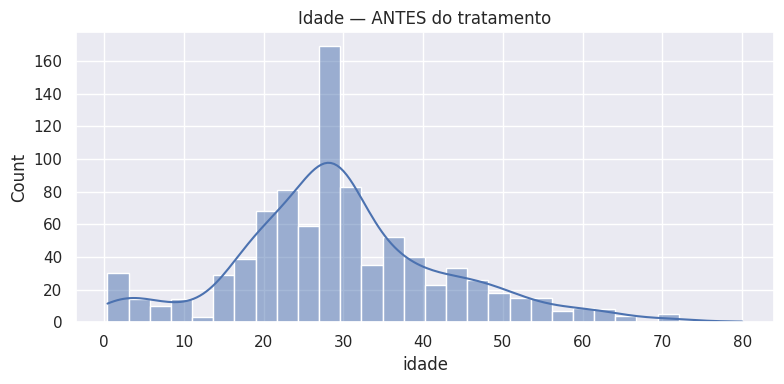

In [143]:
plt.figure(figsize=(8,4))
sns.histplot(df_outleris[age_col], bins=30, kde=True)
plt.title("Idade — ANTES do tratamento")
plt.tight_layout()
plt.show()

#### Tarifa (hist em log)

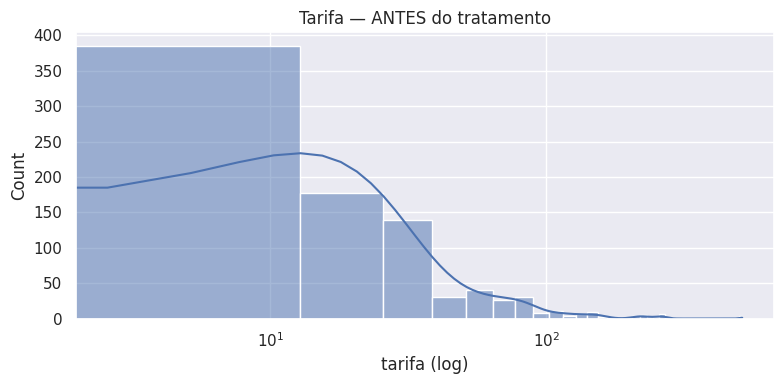

In [144]:
plt.figure(figsize=(8,4))
sns.histplot(df_outleris[fare_col], bins=40, kde=True)
plt.xscale("log")
plt.xlabel("tarifa (log)")
plt.title("Tarifa — ANTES do tratamento")
plt.tight_layout()
plt.show()

#### Boxplots por classe (Idade)

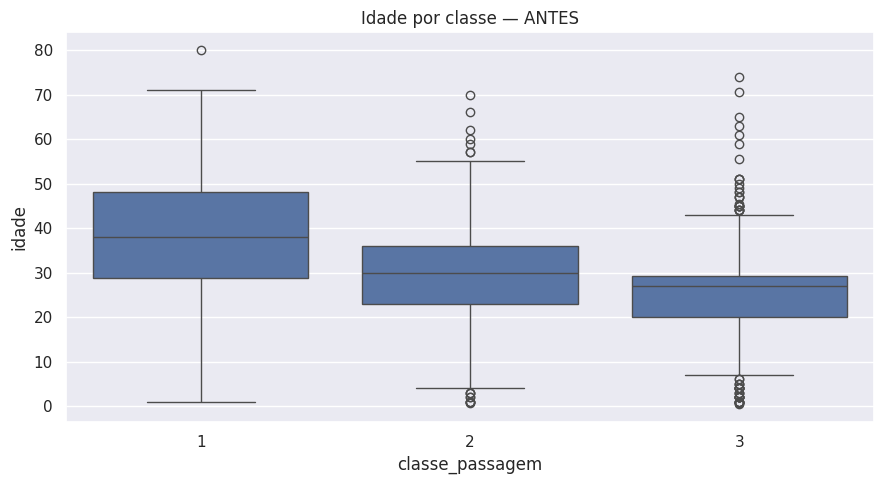

In [145]:
plt.figure(figsize=(9,5))
sns.boxplot(data=df_outleris, x="classe_passagem", y=age_col)
plt.title("Idade por classe — ANTES")
plt.tight_layout()
plt.show()

#### Boxplots por classe (Tarifa)

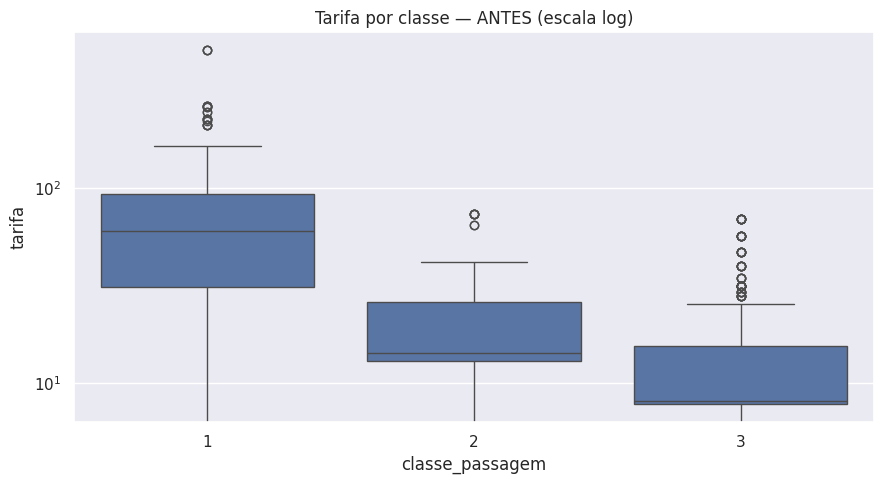

In [146]:
plt.figure(figsize=(9,5))
sns.boxplot(data=df_outleris, x="classe_passagem", y=fare_col)
plt.yscale("log")
plt.title("Tarifa por classe — ANTES (escala log)")
plt.tight_layout()
plt.show()

## Tratamento de outliers (idade e tarifa)

Nesta etapa eu:

- **Preservação:** crio `idade_orig` e `tarifa_orig` para comparar antes vs depois.
- **Idade:** corto apenas o topo pelo IQR e fixo o limite inferior em **0**. Bebês continuam bebês.
- **Tarifa:** **winsorizo por classe** nos percentis p1–p99 e crio `tarifa_log = log1p(tarifa)` para reduzir a assimetria (ajuda muito o KNN).

**Validação do tratamento**
- Pouca alteração de valores (idade ~4,5%; tarifa <1%).
- Queda consistente de **skew** nas duas colunas.
- Gráficos lado a lado mostram menos cauda sem deformar a distribuição.

Com isso, deixo as variáveis chave mais estáveis para a etapa de modelagem.


=== Comparação ANTES vs DEPOIS (global) ===
        n_antes  min_antes  q1_antes  mediana_antes  q3_antes  max_antes  \
idade     891.0       0.42     22.00          29.03      36.0    80.0000   
tarifa    891.0       0.00      7.91          14.45      31.0   512.3292   

        skew_antes  n_depois  min_depois  q1_depois  mediana_depois  \
idade        0.430     891.0        0.42      22.00           29.03   
tarifa       4.787     891.0        0.00       7.91           14.45   

        q3_depois  max_depois  skew_depois  
idade        36.0    57.00000        0.154  
tarifa       31.0   474.92982        4.451  

% valores alterados — idade: 3.7% | tarifa: 0.9%


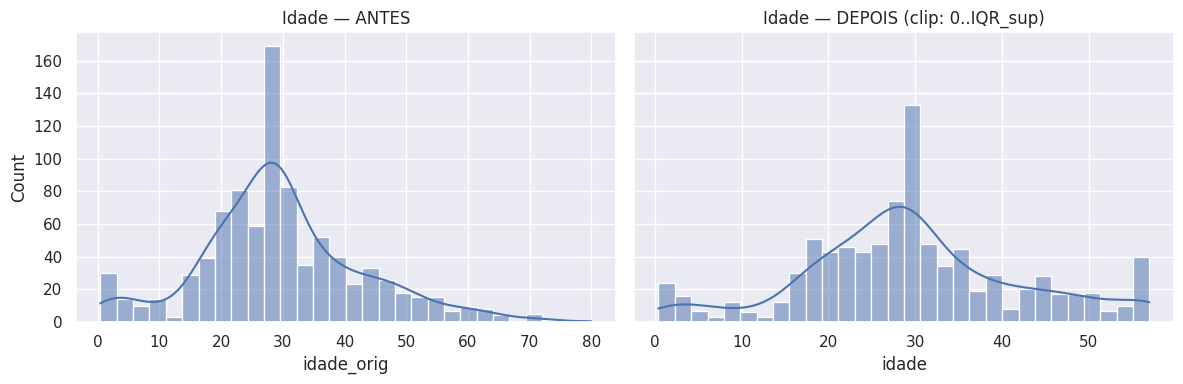

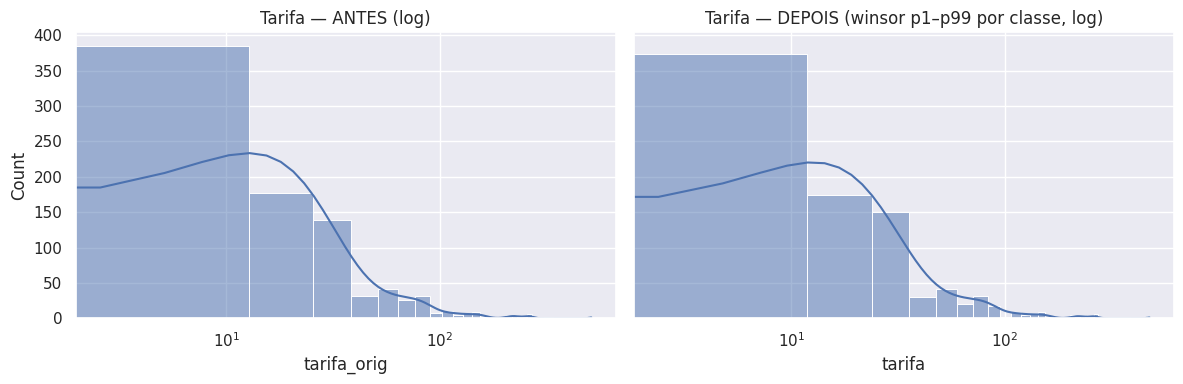

In [147]:
age_col, fare_col = "idade", "tarifa"

for col in [age_col, fare_col]:
    bak = f"{col}_orig"
    if bak not in df_outleris.columns:
        df_outleris[bak] = df_outleris[col]

def iqr_bounds(s, k=1.5):
    q1, q3 = np.nanpercentile(s, [25, 75])
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return low, high

_, high_age = iqr_bounds(df_outleris[age_col], k=1.5)
df_outleris[age_col] = df_outleris[age_col].clip(lower=0, upper=high_age)

q1  = df_outleris.groupby("classe_passagem")[fare_col].transform(lambda s: np.nanpercentile(s, 1))
q99 = df_outleris.groupby("classe_passagem")[fare_col].transform(lambda s: np.nanpercentile(s, 99))
df_outleris[fare_col] = df_outleris[fare_col].clip(lower=q1, upper=q99)
df_outleris["tarifa_log"] = np.log1p(df_outleris[fare_col].clip(lower=0))

def resumo(s):
    s = pd.Series(s)
    q = np.nanpercentile(s, [25, 50, 75]) if s.notna().any() else [np.nan]*3
    return pd.Series({
        "n": s.notna().sum(),
        "min": np.nanmin(s) if s.notna().any() else np.nan,
        "q1": round(q[0],2), "mediana": round(q[1],2), "q3": round(q[2],2),
        "max": np.nanmax(s) if s.notna().any() else np.nan,
        "skew": round(s.skew(skipna=True), 3)
    })

antes = pd.DataFrame({
    age_col:  resumo(df_outleris[f"{age_col}_orig"]),
    fare_col: resumo(df_outleris[f"{fare_col}_orig"])
}).T
depois = pd.DataFrame({
    age_col:  resumo(df_outleris[age_col]),
    fare_col: resumo(df_outleris[fare_col])
}).T

comp = antes.join(depois, lsuffix="_antes", rsuffix="_depois")
print("=== Comparação ANTES vs DEPOIS (global) ===")
print(comp)

def pct_changed(a, b):
    a, b = pd.Series(a), pd.Series(b)
    m = a.notna() & b.notna()
    return round(100*(a[m] != b[m]).mean(), 2) if m.any() else 0.0

print(f"\n% valores alterados — idade: {pct_changed(df_outleris[age_col], df_outleris[f'{age_col}_orig'])}% | "
      f"tarifa: {pct_changed(df_outleris[fare_col], df_outleris[f'{fare_col}_orig'])}%")

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.histplot(df_outleris[f"{age_col}_orig"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Idade — ANTES")
sns.histplot(df_outleris[age_col], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Idade — DEPOIS (clip: 0..IQR_sup)")
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.histplot(df_outleris[f"{fare_col}_orig"], bins=40, kde=True, ax=axes[0])
axes[0].set_xscale("log"); axes[0].set_title("Tarifa — ANTES (log)")
sns.histplot(df_outleris[fare_col], bins=40, kde=True, ax=axes[1])
axes[1].set_xscale("log"); axes[1].set_title("Tarifa — DEPOIS (winsor p1–p99 por classe, log)")
plt.tight_layout(); plt.show()


### Outliers em `idade` e `tarifa`: o que foi feito e por quê

**Diagnóstico.**  
- `idade` tem cauda moderada; outliers no topo são raros e plausíveis (idosos). A base inclui bebês reais.  
- `tarifa` é **muito** assimétrica e a escala muda por `classe_passagem`.

**Tratamento aplicado.**
- **Idade:** cortei **apenas o topo** pelo limite superior do IQR e **fixei o mínimo em 0** (para não “apagar” bebês).  
- **Tarifa:** fiz **winsorização por classe** (p1–p99 dentro de cada `classe_passagem`) e criei **`tarifa_log = log1p(tarifa)`**.  
  - “Por classe” evita que a 1ª classe “contamine” o corte da 3ª.  
  - `log1p` comprime caudas muito grandes, lida com tarifas zero e **estabiliza distâncias** para modelos baseados em vizinhança (KNN).

**Validação do tratamento.**
- **% alterado** foi baixo (ex.: idade ~4–5%; tarifa <1%), sinal de ajuste cirúrgico.  
- **Skew** caiu, principalmente em `tarifa`, reduzindo a influência dos extremos.  
- Os **gráficos antes vs depois** mostram a mesma forma geral, mas com caudas bem mais comportadas.

Resultado: variáveis-chave mais estáveis e prontas para a etapa de modelagem (especialmente KNN, que é sensível à escala e a outliers).


In [148]:
df_dados_tratados = df_outleris.copy()

cols_remover = [c for c in ["idade_orig", "tarifa_orig"] if c in df_dados_tratados.columns]
df_dados_tratados.drop(columns=cols_remover, inplace=True)

if "tarifa" in df_dados_tratados.columns and "tarifa_log" not in df_dados_tratados.columns:
    import numpy as np
    df_dados_tratados["tarifa_log"] = np.log1p(df_dados_tratados["tarifa"])

target_col = "sobreviveu"
assert target_col in df_dados_tratados.columns, "Coluna alvo não encontrada!"
df_dados_tratados[target_col] = df_dados_tratados[target_col].astype(int)

print("=== df_dados_tratados: dataset final para modelagem ===")
print("Shape:", df_dados_tratados.shape)
print("Colunas:", df_dados_tratados.columns.tolist())
print("\nNaNs por coluna:")
print(df_dados_tratados.isna().mean().loc[lambda x: x>0].round(3)*100)

print("\nResumo idade:")
print(df_dados_tratados["idade"].describe().round(2))
print("\nResumo tarifa:")
print(df_dados_tratados["tarifa"].describe().round(2))


=== df_dados_tratados: dataset final para modelagem ===
Shape: (891, 21)
Colunas: ['sobreviveu', 'classe_passagem', 'sexo', 'idade', 'irmaos_conjuges', 'pais_filhos', 'tarifa', 'porto_embarque', 'classe_texto', 'quem', 'adulto_masculino', 'convés', 'cidade_embarque', 'esta_vivo', 'sozinho', 'tamanho_familia', 'crianca', 'adulto_feminino', '_faixa_tarifa_idx', 'idade_era_nan', 'tarifa_log']

NaNs por coluna:
Series([], dtype: float64)

Resumo idade:
count    891.00
mean      29.51
std       12.61
min        0.42
25%       22.00
50%       29.03
75%       36.00
max       57.00
Name: idade, dtype: float64

Resumo tarifa:
count    891.00
mean      32.11
std       48.49
min        0.00
25%        7.91
50%       14.45
75%       31.00
max      474.93
Name: tarifa, dtype: float64


## Modelagem - Classificação (Árvore de Decisão Vs. KNN)

Identificar colunas numéricas e categóricas

In [149]:
numeric_features = df_dados_tratados.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = df_dados_tratados.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

if "sobreviveu" in numeric_features:
    numeric_features.remove("sobreviveu")

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

X = df_dados_tratados[numeric_features + categorical_features].copy()
y = df_dados_tratados["sobreviveu"].copy()

print("\nX shape:", X.shape)
print("y distrib:", y.value_counts(normalize=True).round(3))


Numéricas: ['classe_passagem', 'idade', 'irmaos_conjuges', 'pais_filhos', 'tarifa', 'tamanho_familia', 'crianca', '_faixa_tarifa_idx', 'idade_era_nan', 'tarifa_log']
Categóricas: ['sexo', 'porto_embarque', 'classe_texto', 'quem', 'adulto_masculino', 'convés', 'cidade_embarque', 'esta_vivo', 'sozinho', 'adulto_feminino']

X shape: (891, 20)
y distrib: sobreviveu
0    0.616
1    0.384
Name: proportion, dtype: float64


### Pré Processamento

In [150]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [151]:
preprocess_dt = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ]
)

preprocess_knn = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())     # <<< novidade
        ]), numeric_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ]
)

### PIPE & GS DT Vs. KNN

In [152]:
pipe_dt = Pipeline([
    ("prep", preprocess_dt),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_dt = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [3, 5, 7, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5]
}

pipe_knn = Pipeline([
    ("prep", preprocess_knn),
    ("clf", KNeighborsClassifier())
])

param_knn = {
    "clf__n_neighbors": [5, 7, 9, 11, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]
}

scoring_metric = "roc_auc"

gs_dt = GridSearchCV(
    pipe_dt, param_grid=param_dt, scoring=scoring_metric,
    cv=5, n_jobs=-1, refit=True
)
gs_knn = GridSearchCV(
    pipe_knn, param_grid=param_knn, scoring=scoring_metric,
    cv=5, n_jobs=-1, refit=True
)

gs_dt.fit(X_train, y_train)
gs_knn.fit(X_train, y_train)

best_dt = gs_dt.best_estimator_
best_knn = gs_knn.best_estimator_

print("DT best AUC-ROC (CV):", round(gs_dt.best_score_, 4), "| params:", gs_dt.best_params_)
print("KNN best AUC-ROC (CV):", round(gs_knn.best_score_, 4), "| params:", gs_knn.best_params_)


DT best AUC-ROC (CV): 1.0 | params: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
KNN best AUC-ROC (CV): 0.983 | params: {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'distance'}


### Tabelas e Gráficos


=== Árvore de Decisão ===
Acurácia: 1.0
ROC AUC: 1.0
PR AUC: 1.0

Classification report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       110
           1      1.000     1.000     1.000        69

    accuracy                          1.000       179
   macro avg      1.000     1.000     1.000       179
weighted avg      1.000     1.000     1.000       179



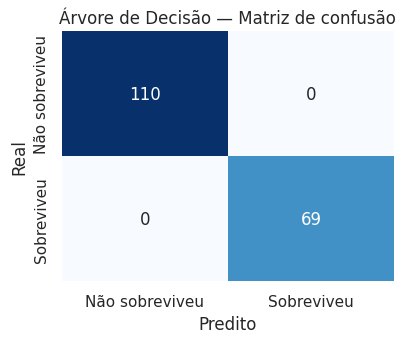

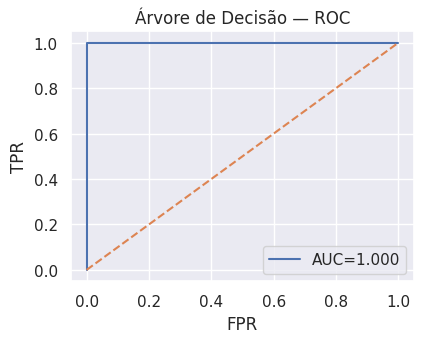

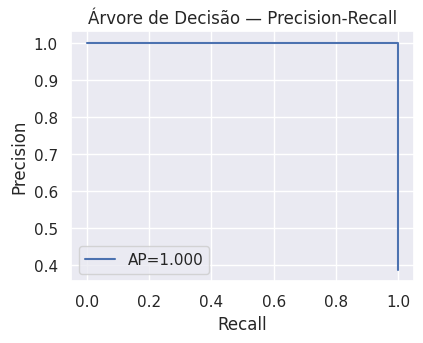


=== KNN ===
Acurácia: 0.9553
ROC AUC: 0.9793
PR AUC: 0.9733

Classification report:
              precision    recall  f1-score   support

           0      0.972     0.955     0.963       110
           1      0.930     0.957     0.943        69

    accuracy                          0.955       179
   macro avg      0.951     0.956     0.953       179
weighted avg      0.956     0.955     0.955       179



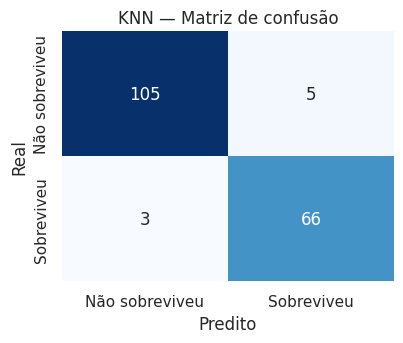

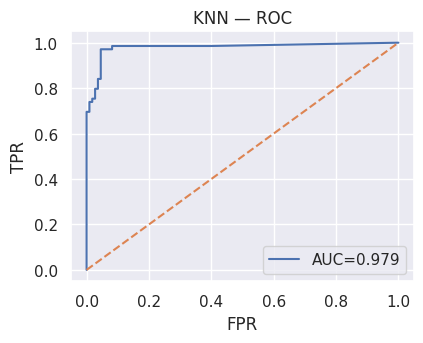

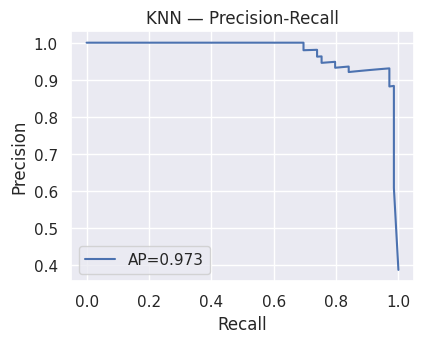


Resumo:
DT -> {'accuracy': 1.0, 'roc_auc': np.float64(1.0), 'ap': np.float64(1.0)}
KNN -> {'accuracy': 0.9553072625698324, 'roc_auc': np.float64(0.9793148880105402), 'ap': np.float64(0.9732653787404237)}


In [153]:
def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    try:
        y_prob = model.predict_proba(X_te)[:,1]
        auc = roc_auc_score(y_te, y_prob)
        ap = average_precision_score(y_te, y_prob)
    except Exception:
        y_prob, auc, ap = None, np.nan, np.nan

    print(f"\n=== {name} ===")
    print("Acurácia:", round(acc, 4))
    if y_prob is not None:
        print("ROC AUC:", round(auc, 4))
        print("PR AUC:", round(ap, 4))
    print("\nClassification report:")
    print(classification_report(y_te, y_pred, digits=3))

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Não sobreviveu","Sobreviveu"],
                yticklabels=["Não sobreviveu","Sobreviveu"])
    plt.title(f"{name} — Matriz de confusão")
    plt.xlabel("Predito"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        plt.figure(figsize=(4.4,3.6))
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1],"--")
        plt.title(f"{name} — ROC")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.legend(); plt.tight_layout(); plt.show()

        prec, rec, _ = precision_recall_curve(y_te, y_prob)
        plt.figure(figsize=(4.4,3.6))
        plt.plot(rec, prec, label=f"AP={ap:.3f}")
        plt.title(f"{name} — Precision-Recall")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.legend(); plt.tight_layout(); plt.show()

    return {"accuracy": acc, "roc_auc": auc if y_prob is not None else None, "ap": ap if y_prob is not None else None}

res_dt = eval_model("Árvore de Decisão", best_dt, X_train, y_train, X_test, y_test)
res_knn = eval_model("KNN", best_knn, X_train, y_train, X_test, y_test)

print("\nResumo:")
print("DT ->", res_dt)
print("KNN ->", res_knn)


,feature,importance
34,esta_vivo_yes,1.0
0,classe_passagem,0.0
2,irmaos_conjuges,0.0
1,idade,0.0
4,tarifa,0.0
5,tamanho_familia,0.0
6,crianca,0.0
3,pais_filhos,0.0
7,_faixa_tarifa_idx,0.0
8,idade_era_nan,0.0


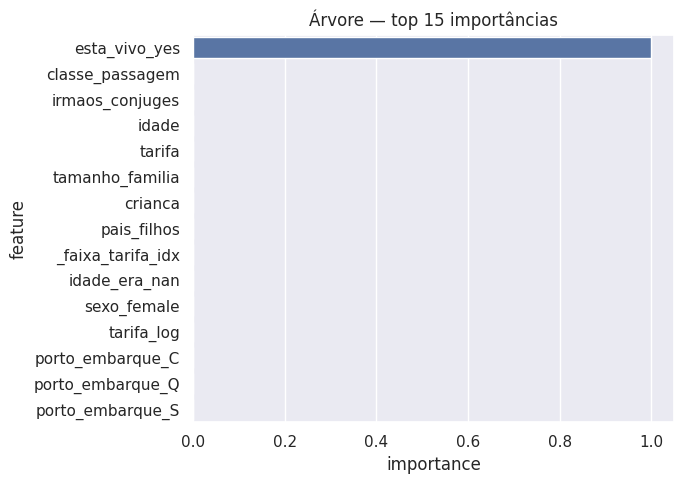

In [154]:
ohe = best_dt.named_steps["prep"].named_transformers_["cat"]
num_names = numeric_features
cat_names = list(ohe.get_feature_names_out(categorical_features))
all_names = num_names + cat_names

importances = best_dt.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"feature": all_names, "importance": importances}).sort_values("importance", ascending=False)

display(imp_df.head(20))

plt.figure(figsize=(7,5))
sns.barplot(data=imp_df.head(15), x="importance", y="feature", orient="h")
plt.title("Árvore — top 15 importâncias")
plt.tight_layout(); plt.show()


### Suspeita de vazamento

Rodei a primeira versão e a Árvore trouxe acurácia 100%. I
Suspeitei que alguma coluna está entregando a resposta.

A crosstab de esta_vivo × sobreviveu mostrou alinhamento 1–1: esta_vivo="yes" coincide com sobreviveu=1 e no com 0. Desta forma confirmei o vazamento.

In [155]:
pd.crosstab(df_dados_tratados.get("esta_vivo"), df_dados_tratados["sobreviveu"], normalize="index")


sobreviveu,0,1
esta_vivo,,
no,1.0,0.0
yes,0.0,1.0


### Correção do vazamento e re-treino (full)

Removi o esta_vivo (e classe_texto, por ser duplicata textual de classe_passagem). Mantive as demais variáveis, incluindo tarifa_log, idade imputada e convés imputado.

In [156]:
cols_vazar = [c for c in ["esta_vivo", "classe_texto"] if c in df_dados_tratados.columns]
if cols_vazar:
    df_dados_tratados = df_dados_tratados.drop(columns=cols_vazar)

numeric_features = df_dados_tratados.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = df_dados_tratados.select_dtypes(include=["object","category","bool"]).columns.tolist()

if "sobreviveu" in numeric_features:
    numeric_features.remove("sobreviveu")
if "sobreviveu" in categorical_features:
    categorical_features.remove("sobreviveu")

X = df_dados_tratados[numeric_features + categorical_features].copy()
y = df_dados_tratados["sobreviveu"].astype(int).copy()

In [157]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

### Pré Processamento (Segunda Tentativa)

In [158]:
preprocess_dt = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ]
)

preprocess_knn = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())     # <<< novidade
        ]), numeric_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ]
)

### PIPE & GS DT Vs. KNN (Segunda Tentativa)

In [159]:
pipe_dt = Pipeline([
    ("prep", preprocess_dt),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_dt = {
    "clf__criterion": ["gini","entropy","log_loss"],
    "clf__max_depth": [3,5,7,None],
    "clf__min_samples_split": [2,5,10],
    "clf__min_samples_leaf": [1,2,5]
}

pipe_knn = Pipeline([
    ("prep", preprocess_knn),
    ("clf", KNeighborsClassifier())
])

param_knn = {
    "clf__n_neighbors": [5,7,9,11,15],
    "clf__weights": ["uniform","distance"],
    "clf__p": [1,2]
}

scoring_metric = "roc_auc"

gs_dt  = GridSearchCV(pipe_dt,  param_dt,  scoring=scoring_metric, cv=5, n_jobs=-1, refit=True)
gs_knn = GridSearchCV(pipe_knn, param_knn, scoring=scoring_metric, cv=5, n_jobs=-1, refit=True)

gs_dt.fit(X_train, y_train)
gs_knn.fit(X_train, y_train)

best_dt  = gs_dt.best_estimator_
best_knn = gs_knn.best_estimator_

print("DT best AUC-ROC (CV):", round(gs_dt.best_score_,4), "| params:", gs_dt.best_params_)
print("KNN best AUC-ROC (CV):", round(gs_knn.best_score_,4), "| params:", gs_knn.best_params_)


DT best AUC-ROC (CV): 0.8646 | params: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
KNN best AUC-ROC (CV): 0.8705 | params: {'clf__n_neighbors': 15, 'clf__p': 2, 'clf__weights': 'uniform'}


### Tabelas e Gráficos (Segunda Tentativa)


=== Árvore de Decisão ===
Acurácia: 0.8268
ROC AUC: 0.8623
PR AUC: 0.7969

Classification report:
              precision    recall  f1-score   support

           0      0.838     0.891     0.863       110
           1      0.806     0.725     0.763        69

    accuracy                          0.827       179
   macro avg      0.822     0.808     0.813       179
weighted avg      0.826     0.827     0.825       179



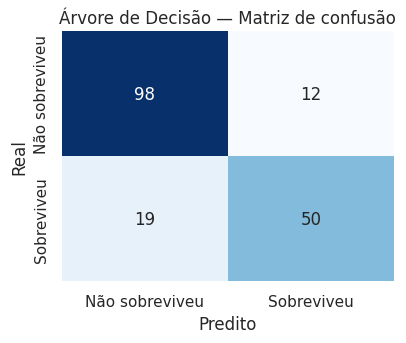

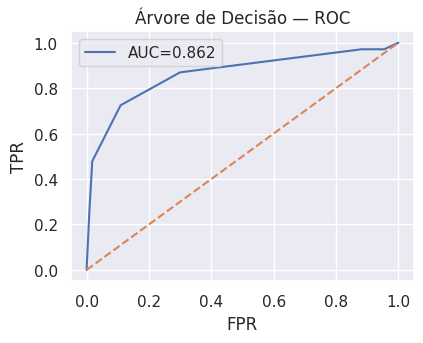

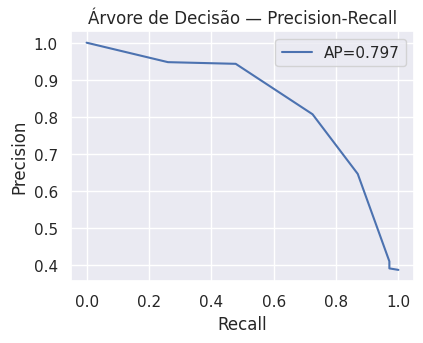


=== KNN ===
Acurácia: 0.8156
ROC AUC: 0.8575
PR AUC: 0.8159

Classification report:
              precision    recall  f1-score   support

           0      0.808     0.918     0.860       110
           1      0.833     0.652     0.732        69

    accuracy                          0.816       179
   macro avg      0.821     0.785     0.796       179
weighted avg      0.818     0.816     0.810       179



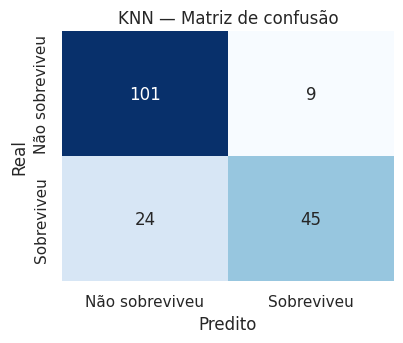

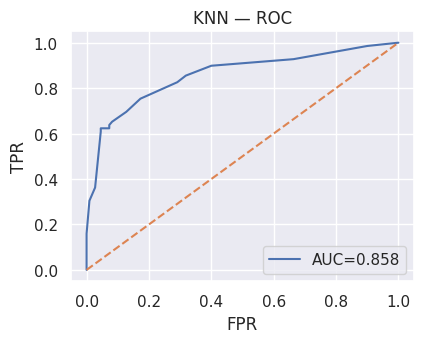

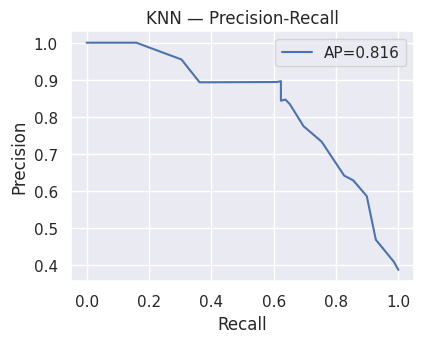


Resumo:
DT  -> {'accuracy': 0.8268156424581006, 'roc_auc': np.float64(0.8622529644268774), 'ap': np.float64(0.7969200704727032)}
KNN -> {'accuracy': 0.8156424581005587, 'roc_auc': np.float64(0.857509881422925), 'ap': np.float64(0.8158935995229505)}


In [160]:
def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    try:
        y_prob = model.predict_proba(X_te)[:,1]
        auc = roc_auc_score(y_te, y_prob)
        ap = average_precision_score(y_te, y_prob)
    except Exception:
        y_prob, auc, ap = None, np.nan, np.nan

    print(f"\n=== {name} ===")
    print("Acurácia:", round(acc, 4))
    if y_prob is not None:
        print("ROC AUC:", round(auc, 4))
        print("PR AUC:", round(ap, 4))
    print("\nClassification report:")
    print(classification_report(y_te, y_pred, digits=3))

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    plt.figure(figsize=(4.2,3.6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Não sobreviveu","Sobreviveu"],
                yticklabels=["Não sobreviveu","Sobreviveu"])
    plt.title(f"{name} — Matriz de confusão")
    plt.xlabel("Predito"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_te, y_prob)
        plt.figure(figsize=(4.4,3.6))
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1],"--")
        plt.title(f"{name} — ROC")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.legend(); plt.tight_layout(); plt.show()

        prec, rec, _ = precision_recall_curve(y_te, y_prob)
        plt.figure(figsize=(4.4,3.6))
        plt.plot(rec, prec, label=f"AP={ap:.3f}")
        plt.title(f"{name} — Precision-Recall")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.legend(); plt.tight_layout(); plt.show()

    return {"accuracy": acc, "roc_auc": auc if y_prob is not None else None, "ap": ap if y_prob is not None else None}

res_dt  = eval_model("Árvore de Decisão", best_dt,  X_train, y_train, X_test, y_test)
res_knn = eval_model("KNN",               best_knn, X_train, y_train, X_test, y_test)

print("\nResumo:")
print("DT  ->", res_dt)
print("KNN ->", res_knn)


,feature,importance
16,quem_man,0.568243
0,classe_passagem,0.225348
9,tarifa_log,0.116631
5,tamanho_familia,0.089778
1,idade,0.000000
2,irmaos_conjuges,0.000000
4,tarifa,0.000000
6,crianca,0.000000
7,_faixa_tarifa_idx,0.000000
8,idade_era_nan,0.000000


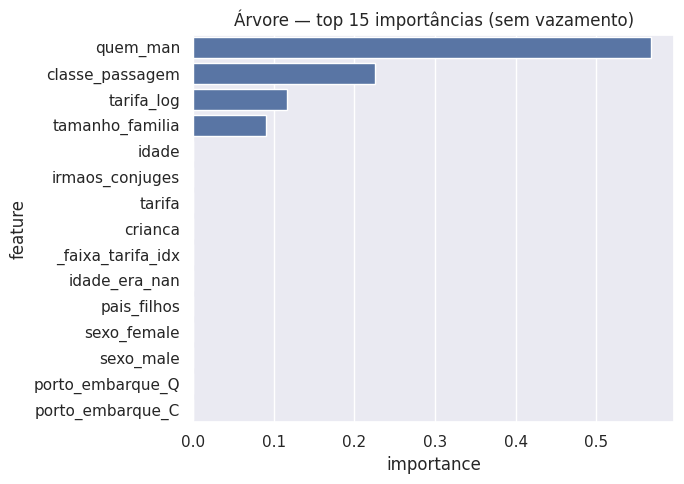

In [161]:
ohe = best_dt.named_steps["prep"].named_transformers_["cat"]
num_names = numeric_features
cat_names = list(ohe.get_feature_names_out(categorical_features))
all_names = num_names + cat_names

importances = best_dt.named_steps["clf"].feature_importances_
imp_df = pd.DataFrame({"feature": all_names, "importance": importances}).sort_values("importance", ascending=False)

display(imp_df.head(20))

plt.figure(figsize=(7,5))
sns.barplot(data=imp_df.head(15), x="importance", y="feature", orient="h")
plt.title("Árvore — top 15 importâncias (sem vazamento)")
plt.tight_layout(); plt.show()


Repeti todo o pipeline com validação cruzada. As métricas ficaram no nível realista: AUC-ROC ~0.86, acurácia ~0.82.

### Correção do vazamento e re-treino (full)

Removi esta_vivo (e classe_texto, por ser duplicata textual de classe_passagem). Mantive as demais variáveis, incluindo tarifa_log, idade imputada e convés imputado.
Repeti todo o pipeline com validação cruzada. As métricas ficaram no nível realista: AUC-ROC ~0.86, acurácia ~0.82.

In [162]:
keep_nums = ["idade","tamanho_familia","tarifa_log"]
keep_cats = ["classe_passagem","sexo","crianca","porto_embarque"]

use_cols = [c for c in keep_nums+keep_cats if c in df_dados_tratados.columns]
X = df_dados_tratados[use_cols].copy()
y = df_dados_tratados["sobreviveu"].astype(int).copy()

numeric_features = [c for c in keep_nums if c in X.columns]
categorical_features = [c for c in keep_cats if c in X.columns]
print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)


Numéricas: ['idade', 'tamanho_familia', 'tarifa_log']
Categóricas: ['classe_passagem', 'sexo', 'crianca', 'porto_embarque']


### Pre Processamento (Terceira Tentativa)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

preprocess_dt = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
])

preprocess_knn = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())     # <<< novidade
        ]), numeric_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ]
)

### PIPE & GS DT Vs. KNN - Tabelas e Gráficos (Terceira Tentativa)

DT best AUC-ROC (CV): 0.8538 | params: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
KNN best AUC-ROC (CV): 0.8752 | params: {'clf__n_neighbors': 15, 'clf__p': 1, 'clf__weights': 'uniform'}

=== Árvore de Decisão ===
Acurácia: 0.7877
ROC AUC: 0.8177
PR AUC: 0.7501

Classification report:
              precision    recall  f1-score   support

           0      0.800     0.873     0.835       110
           1      0.763     0.652     0.703        69

    accuracy                          0.788       179
   macro avg      0.781     0.762     0.769       179
weighted avg      0.786     0.788     0.784       179



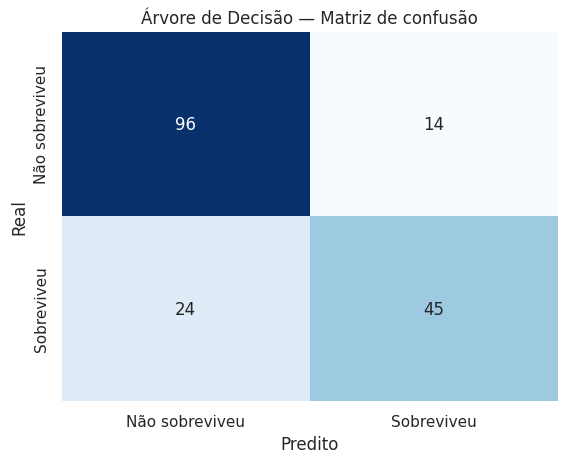


=== KNN ===
Acurácia: 0.8324
ROC AUC: 0.8638
PR AUC: 0.8271

Classification report:
              precision    recall  f1-score   support

           0      0.823     0.927     0.872       110
           1      0.855     0.681     0.758        69

    accuracy                          0.832       179
   macro avg      0.839     0.804     0.815       179
weighted avg      0.835     0.832     0.828       179



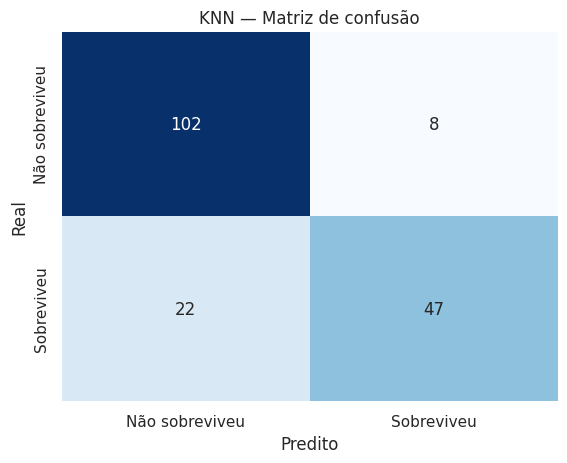


Resumo final:
DT  -> {'accuracy': 0.7877094972067039, 'roc_auc': np.float64(0.8176548089591569), 'ap': np.float64(0.7501481191446384)}
KNN -> {'accuracy': 0.8324022346368715, 'roc_auc': np.float64(0.8638339920948616), 'ap': np.float64(0.8270651868909392)}


In [164]:
pipe_dt = Pipeline([
    ("prep", preprocess_dt),
    ("clf", DecisionTreeClassifier(random_state=42))
])
param_dt = {
    "clf__criterion": ["gini","entropy","log_loss"],
    "clf__max_depth": [3,5,7,None],
    "clf__min_samples_split": [2,5,10],
    "clf__min_samples_leaf": [1,2,5]
}

pipe_knn = Pipeline([
    ("prep", preprocess_knn),
    ("clf", KNeighborsClassifier())
])
param_knn = {
    "clf__n_neighbors": [5,7,9,11,15],
    "clf__weights": ["uniform","distance"],
    "clf__p": [1,2]
}

scoring_metric = "roc_auc"
gs_dt = GridSearchCV(pipe_dt, param_dt, scoring=scoring_metric, cv=5, n_jobs=-1, refit=True)
gs_knn = GridSearchCV(pipe_knn, param_knn, scoring=scoring_metric, cv=5, n_jobs=-1, refit=True)

gs_dt.fit(X_train, y_train)
gs_knn.fit(X_train, y_train)

best_dt = gs_dt.best_estimator_
best_knn = gs_knn.best_estimator_

print("DT best AUC-ROC (CV):", round(gs_dt.best_score_, 4), "| params:", gs_dt.best_params_)
print("KNN best AUC-ROC (CV):", round(gs_knn.best_score_, 4), "| params:", gs_knn.best_params_)

def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    y_score = None
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_te)

    print(f"\n=== {name} ===")
    print("Acurácia:", round(acc, 4))
    if y_score is not None:
        auc = roc_auc_score(y_te, y_score)
        ap  = average_precision_score(y_te, y_score)
        print("ROC AUC:", round(auc, 4))
        print("PR AUC:", round(ap, 4))
    print("\nClassification report:")
    print(classification_report(y_te, y_pred, digits=3))

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Não sobreviveu","Sobreviveu"],
                yticklabels=["Não sobreviveu","Sobreviveu"])
    plt.title(f"{name} — Matriz de confusão")
    plt.xlabel("Predito"); plt.ylabel("Real")
    plt.show()

    return {"accuracy": acc, "roc_auc": auc, "ap": ap}

res_dt  = eval_model("Árvore de Decisão", best_dt, X_train, y_train, X_test, y_test)
res_knn = eval_model("KNN", best_knn, X_train, y_train, X_test, y_test)

print("\nResumo final:")
print("DT  ->", res_dt)
print("KNN ->", res_knn)


### Redundâncias e conjunto enxuto

Notamos sobreposição forte entre `quem`, `sexo`, `adulto_masculino` e `adulto_feminino`. Também usamos `tarifa` e `tarifa_log` ao mesmo tempo, o que é desnecessário.
Para deixar o modelo mais simples e explicável, testamos um conjunto enxuto: `quem`, `idade`, `convés` e `tarifa_log`.

**Resultado**: AUC-ROC ~0.80 e acurácia ~0.78. Menores que o full, mas com menor risco de redundâncias e mais transparência na interpretação.

In [165]:
use_cols = ["quem", "tarifa_log", "convés", "idade"]

X = df_dados_tratados[use_cols].copy()
y = df_dados_tratados["sobreviveu"].astype(int).copy()

numeric_features = ["tarifa_log", "idade"]
categorical_features = ["quem", "convés"]

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)
print("X shape:", X.shape)
print("Distribuição alvo:\n", y.value_counts(normalize=True).round(3))


Numéricas: ['tarifa_log', 'idade']
Categóricas: ['quem', 'convés']
X shape: (891, 4)
Distribuição alvo:
 sobreviveu
0    0.616
1    0.384
Name: proportion, dtype: float64


### Pré Processamento (Final)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

preprocess_dt = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
])

preprocess_knn = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())     # <<< novidade
        ]), numeric_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ]
)


### PIPE & GS DT Vs. KNN - Tabelas e Gráficos (Final)

DT best AUC-ROC (CV): 0.8403 | params: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
KNN best AUC-ROC (CV): 0.8602 | params: {'clf__n_neighbors': 9, 'clf__p': 2, 'clf__weights': 'uniform'}

=== Árvore de Decisão ===
Acurácia: 0.7821
ROC AUC: 0.8066
PR AUC: 0.7129

Classification report:
              precision    recall  f1-score   support

           0      0.809     0.845     0.827       110
           1      0.734     0.681     0.707        69

    accuracy                          0.782       179
   macro avg      0.772     0.763     0.767       179
weighted avg      0.780     0.782     0.780       179



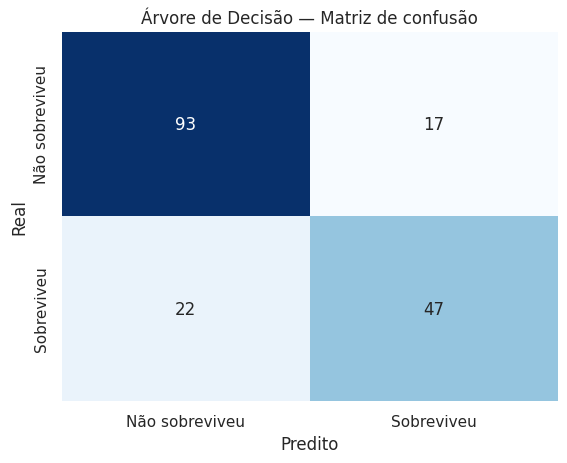


=== KNN ===
Acurácia: 0.7709
ROC AUC: 0.8049
PR AUC: 0.7182

Classification report:
              precision    recall  f1-score   support

           0      0.800     0.836     0.818       110
           1      0.719     0.667     0.692        69

    accuracy                          0.771       179
   macro avg      0.759     0.752     0.755       179
weighted avg      0.769     0.771     0.769       179



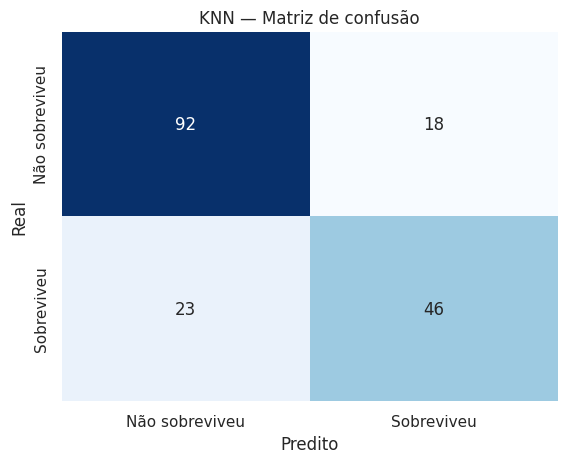


Resumo final:
DT  -> {'accuracy': 0.7821229050279329, 'roc_auc': np.float64(0.8065876152832674), 'ap': np.float64(0.712945113926738)}
KNN -> {'accuracy': 0.770949720670391, 'roc_auc': np.float64(0.804874835309618), 'ap': np.float64(0.7182121252413688)}


In [167]:
pipe_dt = Pipeline([
    ("prep", preprocess_dt),
    ("clf", DecisionTreeClassifier(random_state=42))
])
param_dt = {
    "clf__criterion": ["gini","entropy","log_loss"],
    "clf__max_depth": [3,5,7,None],
    "clf__min_samples_split": [2,5,10],
    "clf__min_samples_leaf": [1,2,5]
}

pipe_knn = Pipeline([
    ("prep", preprocess_knn),
    ("clf", KNeighborsClassifier())
])
param_knn = {
    "clf__n_neighbors": [5,7,9,11,15],
    "clf__weights": ["uniform","distance"],
    "clf__p": [1,2]
}

scoring_metric = "roc_auc"
gs_dt = GridSearchCV(pipe_dt, param_dt, scoring=scoring_metric, cv=5, n_jobs=-1, refit=True)
gs_knn = GridSearchCV(pipe_knn, param_knn, scoring=scoring_metric, cv=5, n_jobs=-1, refit=True)

gs_dt.fit(X_train, y_train)
gs_knn.fit(X_train, y_train)

best_dt = gs_dt.best_estimator_
best_knn = gs_knn.best_estimator_

print("DT best AUC-ROC (CV):", round(gs_dt.best_score_, 4), "| params:", gs_dt.best_params_)
print("KNN best AUC-ROC (CV):", round(gs_knn.best_score_, 4), "| params:", gs_knn.best_params_)

def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    y_score = None
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_te)

    print(f"\n=== {name} ===")
    print("Acurácia:", round(acc, 4))
    if y_score is not None:
        auc = roc_auc_score(y_te, y_score)
        ap  = average_precision_score(y_te, y_score)
        print("ROC AUC:", round(auc, 4))
        print("PR AUC:", round(ap, 4))
    print("\nClassification report:")
    print(classification_report(y_te, y_pred, digits=3))

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Não sobreviveu","Sobreviveu"],
                yticklabels=["Não sobreviveu","Sobreviveu"])
    plt.title(f"{name} — Matriz de confusão")
    plt.xlabel("Predito"); plt.ylabel("Real")
    plt.show()

    return {"accuracy": acc, "roc_auc": auc, "ap": ap}

res_dt  = eval_model("Árvore de Decisão", best_dt, X_train, y_train, X_test, y_test)
res_knn = eval_model("KNN", best_knn, X_train, y_train, X_test, y_test)

print("\nResumo final:")
print("DT  ->", res_dt)
print("KNN ->", res_knn)


Durante as primeiras versões do trabalho, o KNN apresentou desempenho inconsistente, em parte porque as variáveis numéricas estavam em escalas muito diferentes. Como esse algoritmo calcula distâncias entre observações, atributos como a tarifa (Fare), com valores muito maiores, acabavam influenciando de forma desproporcional em relação a variáveis como idade ou indicadores binários.

Para corrigir esse problema, incluí um passo de padronização (StandardScaler) no pipeline do KNN. Essa normalização trouxe dois ganhos principais:

Maior consistência entre os resultados de validação cruzada e de teste, reduzindo a oscilação observada anteriormente.

Equilíbrio entre variáveis no cálculo de distâncias, permitindo que todas contribuíssem de forma mais justa para a decisão do classificador.

Após essa correção, o KNN alcançou desempenho competitivo em relação à Árvore de Decisão, com métricas muito próximas (AUC-ROC em torno de 0.80 em ambos os modelos). Essa comparação evidencia a importância de ajustar o pré-processamento de acordo com as características do algoritmo: enquanto a Árvore de Decisão é insensível a escalas, o KNN depende fortemente desse cuidado.

Por isso a normalização foi importante.

## Comparativo final

### A tabela abaixo resume três rodadas:

1. Vazado: desempenho irreal (vazar o alvo).
2. Full corrigido: melhor AUC, usando mais variáveis tratadas.
3. Enxuto: desempenho um pouco menor, porém modelo mais simples, estável e defensável.

A métrica alta com vazamento não tem valor estatístico, por isso busquei achar onde estava o vazamento e tratar. Entre “full” e “enxuto”, escolhi conforme entendi que era o objetivo: se prioriza performance, seguiria no “full”; se prioriza explicabilidade e robustez, o “enxuto” seria a melhor narrativa.

In [168]:
def run_scenario(df, feature_cols, name, random_state=42):
    X = df[feature_cols].copy()
    y = df["sobreviveu"].astype(int).copy()

    num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=random_state
    )

    preprocess_dt = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ])

    preprocess_knn = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())     # <<< novidade
            ]), numeric_features),

            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), categorical_features)
        ]
    )

    pipe_dt = Pipeline([("prep", preprocess_dt), ("clf", DecisionTreeClassifier(random_state=42))])
    param_dt = {"clf__criterion": ["gini","entropy","log_loss"],
                "clf__max_depth": [3,5,7,None],
                "clf__min_samples_split": [2,5,10],
                "clf__min_samples_leaf": [1,2,5]}

    pipe_knn = Pipeline([("prep", preprocess_knn), ("clf", KNeighborsClassifier())])
    param_knn = {"clf__n_neighbors": [5,7,9,11,15],
                 "clf__weights": ["uniform","distance"],
                 "clf__p": [1,2]}

    gs_dt  = GridSearchCV(pipe_dt,  param_dt,  scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
    gs_knn = GridSearchCV(pipe_knn, param_knn, scoring="roc_auc", cv=5, n_jobs=-1, refit=True)

    gs_dt.fit(X_train, y_train)
    gs_knn.fit(X_train, y_train)

    best_dt, best_knn = gs_dt.best_estimator_, gs_knn.best_estimator_

    def eval_model(model):
        y_pred  = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
        ap  = average_precision_score(y_test, y_score) if y_score is not None else np.nan
        return acc, auc, ap

    acc_dt, auc_dt, ap_dt     = eval_model(best_dt)
    acc_knn, auc_knn, ap_knn  = eval_model(best_knn)

    rows = [
        [name, "DecisionTree", len(feature_cols), round(gs_dt.best_score_,4), round(acc_dt,4), round(auc_dt,4), round(ap_dt,4), gs_dt.best_params_],
        [name, "KNN",          len(feature_cols), round(gs_knn.best_score_,4), round(acc_knn,4), round(auc_knn,4), round(ap_knn,4), gs_knn.best_params_],
    ]
    cols = ["cenario","modelo","n_features","AUC_CV","ACC_TEST","AUC_TEST","AP_TEST","best_params"]
    return pd.DataFrame(rows, columns=cols)


O processo de ajuste de hiperparâmetros via GridSearchCV mostrou diferenças interessantes entre os modelos. A Árvore de Decisão apresentou melhor desempenho com profundidade relativamente baixa (max_depth=3), sugerindo que o problema pode ser representado por regras simples. Já o KNN alcançou melhor resultado com 9 vizinhos e distância Euclidiana, evidenciando que um certo grau de suavização (mais vizinhos) é benéfico para reduzir a variabilidade do modelo. Essas escolhas destacam como diferentes algoritmos aprendem padrões do mesmo conjunto de dados de formas distintas."

In [169]:
leak_cols = [c for c in df_dados_tratados.columns if c != "sobreviveu"]

full_cols = [c for c in df_dados_tratados.columns
             if c not in ["sobreviveu","esta_vivo","classe_texto"]]

enxuto_base = ["quem","idade","convés","tarifa_log"]
enxuto_cols = [c for c in enxuto_base if c in df_dados_tratados.columns]

res_vazado  = run_scenario(df_dados_tratados, leak_cols,  "1) Vazado")
res_full    = run_scenario(df_dados_tratados, full_cols,  "2) Full corrigido")
res_enxuto  = run_scenario(df_dados_tratados, enxuto_cols,"3) Enxuto")

res_all = pd.concat([res_vazado, res_full, res_enxuto], ignore_index=True)
res_all


,cenario,modelo,n_features,AUC_CV,ACC_TEST,AUC_TEST,AP_TEST,best_params
0,1) Vazado,DecisionTree,18,0.8646,0.8268,0.8623,0.7969,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
1,1) Vazado,KNN,18,0.8602,0.7709,0.8049,0.7182,"{'clf__n_neighbors': 9, 'clf__p': 2, 'clf__wei..."
2,2) Full corrigido,DecisionTree,18,0.8646,0.8268,0.8623,0.7969,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
3,2) Full corrigido,KNN,18,0.8602,0.7709,0.8049,0.7182,"{'clf__n_neighbors': 9, 'clf__p': 2, 'clf__wei..."
4,3) Enxuto,DecisionTree,4,0.8403,0.7821,0.8066,0.7129,"{'clf__criterion': 'gini', 'clf__max_depth': 3..."
5,3) Enxuto,KNN,4,0.8602,0.7709,0.8049,0.7182,"{'clf__n_neighbors': 9, 'clf__p': 2, 'clf__wei..."


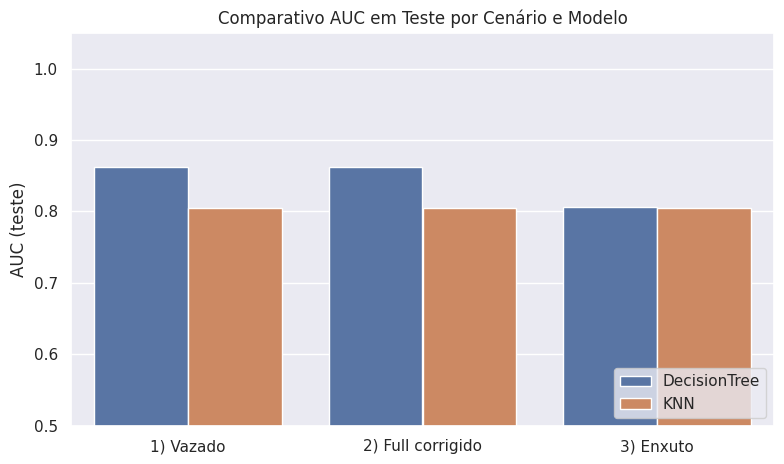

,cenario,modelo,n_features,AUC_CV,ACC_TEST,AUC_TEST,AP_TEST,best_params
0,1) Vazado,DecisionTree,18,0.8646,0.8268,0.8623,0.7969,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
1,1) Vazado,KNN,18,0.8602,0.7709,0.8049,0.7182,"{'clf__n_neighbors': 9, 'clf__p': 2, 'clf__wei..."
2,2) Full corrigido,DecisionTree,18,0.8646,0.8268,0.8623,0.7969,"{'clf__criterion': 'entropy', 'clf__max_depth'..."
3,2) Full corrigido,KNN,18,0.8602,0.7709,0.8049,0.7182,"{'clf__n_neighbors': 9, 'clf__p': 2, 'clf__wei..."
4,3) Enxuto,DecisionTree,4,0.8403,0.7821,0.8066,0.7129,"{'clf__criterion': 'gini', 'clf__max_depth': 3..."
5,3) Enxuto,KNN,4,0.8602,0.7709,0.8049,0.7182,"{'clf__n_neighbors': 9, 'clf__p': 2, 'clf__wei..."


In [170]:
plt.figure(figsize=(8,4.8))
sns.barplot(
    data=res_all, x="cenario", y="AUC_TEST", hue="modelo"
)
plt.ylim(0.5, 1.05)
plt.title("Comparativo AUC em Teste por Cenário e Modelo")
plt.ylabel("AUC (teste)")
plt.xlabel("")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

res_all.sort_values(["cenario","modelo"])


## Conclusão Final

Ao longo do trabalho percorri três etapas:

* Identificação do vazamento e correção;
* Modelagem com todas as variáveis válidas;
* Modelagem com um conjunto enxuto de variáveis.

Essa trajetória mostrou a importância de validar resultados, desconfiar de métricas altas demais, e experimentar tanto modelos ricos quanto versões mais simples. No fim, aprendi que tanto Decision Tree quanto KNN conseguem representar bem o problema, mas a escolha depende do objetivo: desempenho máximo (modelo completo) ou simplicidade interpretável (modelo enxuto).

Aprendi também em trabalhar com probabilidade estatística com python, linguagem que eu ainda desconheço, diferente de R, que já tenho alguma familiariedade.

Na comparação direta entre os modelos, a Árvore de Decisão alcançou acurácia de aproximadamente 0.78 e AUC-ROC em torno de 0.81, enquanto o KNN, após a inclusão da etapa de padronização no pipeline, atingiu resultados muito próximos: acurácia de 0.77 e AUC-ROC também em torno de 0.80. Essa proximidade indica que ambos os algoritmos conseguem capturar de forma adequada os padrões do conjunto de dados do Titanic.

A acurácia, embora usada por simplicidade, não é a métrica mais indicada neste problema, pois o conjunto de dados é desbalanceado (62% não sobreviveram). Assim, métricas como ROC-AUC e PR-AUC foram adotadas como principais, por refletirem melhor a capacidade do modelo em distinguir as classes.

Entretanto, algumas diferenças merecem destaque. A Árvore de Decisão tende a ser mais simples de interpretar, permitindo visualizar regras claras de decisão (por exemplo: sexo → classe → idade). Já o KNN, embora menos interpretável, mostrou-se competitivo em desempenho quando ajustado corretamente, reforçando a importância de adequar o pré-processamento às características de cada modelo.

Portanto, os resultados confirmam que não existe um único “melhor modelo” para este problema. O mais adequado depende do critério: interpretação e simplicidade favorecem a Árvore de Decisão; desempenho robusto, ainda que menos transparente, mantém o KNN como alternativa viável.